In [1]:
import MeCab

import re
import os

import numpy as np
import pandas as pd

import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# sns.set(font='IPAexGothic')

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pwd

/Users/kenta_kasugai/competition/nishika_akutagawa/notebook


In [3]:
train = pd.read_csv(f'../input/train.csv')
test = pd.read_csv(f'../input/test.csv')

In [4]:
train.head()

,writing_id,body,author
0,0,\r\n 先ごろの本欄に僕の「風報」にかいた「天皇陛下に捧ぐる言葉」を評して俗うけを狙った媚...,0
1,1,\r\n 旅の眼に映じた外国の正月をといふお需めで、一昔前の記憶から探してみたが、其処にはほ...,0
2,2,\r\n 或る心持のよい夕方、日比谷公園の樹の繁みの間で、若葉楓の梢を眺めていたら、どこから...,0
3,3,\r\n\r\n［＃３字下げ］一［＃「一」は中見出し］\r\n\r\n 島々《しま／＼》と云...,1
4,7,\r\n\r\n 或る田舎に母と子とが住んでいた。そして或る年の秋、次のようなことがあった。...,0


In [5]:
len(train)

3312

In [6]:
test.head()

,writing_id,body
0,4,\r\n\r\n 一\r\n\r\n 夕方降り出した雨はその晩遅くまで続いた。しとし...
1,5,\r\n\r\n この「東北文学」という雑誌の貴重な紙面の端をわずか拝借して申し上げます。ど...
2,6,\r\n\r\n 幼少のころ、高知《こうち》の城下から東に五六里離れた親類の何かの饗宴《きょ...
3,10,\r\n\r\n ○\r\n「三人姉妹」で、マーシャがどんな風に活か...
4,11,\r\n\r\n［＃５字下げ］眼鏡［＃「眼鏡」は中見出し］\r\n\r\n 或日、趣味に関し...


## 漢字・ひらがな…

In [7]:
#http://tamomo.com/Aozora/jisyo/kyuuji_tabei006.txt

old_kanji = pd.read_table("../input/old_kanji.tsv", usecols=["kanji"])

In [8]:
old_kanji

,kanji
0,擧
1,當
2,會
3,相變らず
4,愛國心
5,合圖
6,會津
7,曉
8,安藝
9,※［＃「厭／（餮－殄）」、第4水準2-92-73］


In [9]:
old_kanji = old_kanji.drop(index=[1808, 1809, 1810])["kanji"].values

In [10]:
old_kanji

array(['擧', '當', '會', ..., '譯', '惡', '灣'], dtype=object)

In [11]:
old_kana = np.array(["ヰ", "ヱ", "ゐ", "ゑ"])

In [12]:
old_kana

array(['ヰ', 'ヱ', 'ゐ', 'ゑ'], dtype='<U1')

In [13]:
re.findall('ゑ', "ともゑ")

['ゑ']

In [14]:
komoji = np.array(["ぁ", "ぃ", "ぅ", "ぇ", "ぉ", "っ", "ゃ", "ゅ", "ょ", "ゎ"])

In [15]:
hagyo = np.array(["は", "ひ", "ふ", "へ", "ほ"])

In [16]:
len(re.findall('\d', repr(train["body"][0])))

24

In [17]:
train["body"][1].replace("\u3000", "").strip().replace("\r\n", "").strip()

'旅の眼に映じた外国の正月をといふお需めで、一昔前の記憶から探してみたが、其処にはほとんど、「お正月」といふものがない。我々の頭に幼少の頃から浸み込んでゐるお正月、新年、といふものとは、およそかけ離れたものであつた。古い一年が逝き、新しい年が来るといふ事を、我々の祖先が何故こんなに重大事とし華やかな儀式を以つて迎へる様になつたか、その穿鑿は別として、欧米人は、実にあつさりとこれを扱つてゐる。私は丁度四回の新年を巴里で迎へたわけであるが、仏蘭西人の下宿に住み、故国からの留学生とか、大使館関係の人達との交際なども少なかつたので、猶更、その正月はひつそりしたものであつた。最初の年はそれでも、「あ、今時分は弟妹達、雑煮でも祝つてゐるかな」とか、母の得意の煎田作で飯を食べてみたいとか思つたりしたものであるが、次の年からは、そんな感傷も薄らぎ、結句、煩雑な儀礼に縛られないで済む身軽さの気持に、のびのびと己れを浸してゐた。それでも大晦日の晩は、レヴエイヨンといつて、みんな大概レストランか何かに出かけ、知人等と食事を供にし、踊つたり、唄つたりで、夜を更かす、つまりそれが外国では、新年を迎へる気持の唯一の現はれと云へよう。その騒ぎも、夜が明ける頃には、何処もすつかり静まつて、街上にも屋内にも、平常と何の変りもない一日が来る。起きて、食堂にでも出て来ると、流石、下宿の女主人が、「お早う」の代りに「お目出度う」と云つてくれる。しかし、それもほんの軽い挨拶で、別に、その言葉から正月を感じさせてくれるやうなものではない。カトリック教の国に、「王様の日」といふのがある。これは偶然、日本の「松の内」にあるお祭り日であつて、向ふの人達には、新年とは関りのないものであるが、日本人である私などには、時が時なので、ちよつとその日はお正月らしい気分を味はへるものだつた。それは、聖書にある通り、基督が生れた時、東方の国の博士達が星の占ひで、ベツレヘムに偉い人が生れたと云つたのにより、東方の国の王が、その誕生を祝ひに来た、といふその日を祝ふのである。この日、各家庭では、独身だつたり、遠くから学校の寄宿舎に来てゐる人など、家を持たない人達を招き、煖炉を前にして、カルタや、唄や、隠し芸の披露や、極く呑気に家庭的な娯楽にうち興じる。そして、この日には、食後に必ず特別の菓子が出る。丁度誕生日やクリスマスの時の様な大き

In [18]:
# moji_list = []
# kanji_list = []
# hira_list = []
# kana_list = []
# suji_list = []
# eigo_list = []
# kyukanji_list = []
# kyuhira_list = []
# komoji_list = []
# hagyo_list = []
# for body in train["body"][:3]:
#     body = body.replace("\u3000", "").strip().replace("\r\n", "").strip()
#     moji_list.append(len(body))
#     kanji_list.append(len(re.findall("[\u4E00-\u9FD0]", repr(body))))
#     hira_list.append(len(re.findall('[ぁ-ゟ]', repr(body))))
#     kana_list.append(len(re.findall('[\ァ-ヿ]', repr(body)))+len(re.findall('[ｦ-ﾟ]', repr(body))))
#     suji_list.append(len(re.findall('\d', repr(body))))
#     eigo_list.append(len(re.findall('[a-zA-Zａ-ｚＡ-Ｚ]', repr(body))))
#     kyukanji_list.append(sum([len(re.findall(s, repr(body))) for s in old_kanji]))
#     kyuhira_list.append(sum([len(re.findall(s, repr(body))) for s in old_kana]))
#     komoji_list.append(sum([len(re.findall(s, repr(body))) for s in komoji]))
#     hagyo_list.append(sum([len(re.findall(s, repr(body))) for s in hagyo]))

In [19]:
def hyoki(bodies):
    df = pd.DataFrame(columns=["letter_number", "kanji", "hiragana", "katakana", "digit",
                               "alphabet", "old_kanji", "old_hiragana", "old", "lowercase",
                               "hagyo", "kakko", "kagikakko", "kutoten"])
    for i, body in enumerate(bodies):
        body = body.replace("\u3000", "").strip().replace("\r\n", "").strip()
        df.loc[i, "kanji"] = len(re.findall("[\u4E00-\u9FD0]", repr(body)))/len(body)
        df.loc[i, "hiragana"] = len(re.findall('[ぁ-ゟ]', repr(body)))/len(body)
        df.loc[i, "katakana"] = (len(re.findall('[\ァ-ヿ]', repr(body)))+len(re.findall('[ｦ-ﾟ]', repr(body))))/len(body)
        df.loc[i, "digit"] = len(re.findall('\d', repr(body)))/len(body)
        df.loc[i, "alphabet"] = len(re.findall('[a-zA-Zａ-ｚＡ-Ｚ]', repr(body)))/len(body)
        df.loc[i, "old_kanji"] = sum([len(re.findall(s, repr(body))) for s in old_kanji])/len(body)
        df.loc[i, "old_hiragana"] = sum([len(re.findall(s, repr(body))) for s in old_kana])/len(body)
        df.loc[i, "old"] = df.loc[i, "old_kanji"]+df.loc[i, "old_hiragana"]
        df.loc[i, "lowercase"] = sum([len(re.findall(s, repr(body))) for s in komoji])/len(body)
        df.loc[i, "hagyo"] = sum([len(re.findall(s, repr(body))) for s in hagyo])/len(body)
        df.loc[i, "kakko"] = len(re.findall('[（-）]', repr(body)))/len(body)
        df.loc[i, "kagikakko"] = len(re.findall('[「-」]', repr(body)))/len(body)
        df.loc[i, "kutoten"] = len(re.findall('[、-。]', repr(body)))/len(body)
        df.loc[i, "letter_number"] = len(body)
    df = df.astype(float)
    return df

In [20]:
num_sample = 100

In [21]:
hyoki_df = hyoki(train["body"][:num_sample])

In [22]:
tmp = pd.concat([hyoki_df, train["author"][:num_sample]], axis=1)
tmp

,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,lowercase,hagyo,kakko,kagikakko,kutoten,author
0,651.0,0.298003,0.594470,0.036866,0.000000,0.000000,0.001536,0.000000,0.001536,0.007680,0.016897,0.000000,0.012289,0.058372,0
1,1363.0,0.319883,0.562729,0.026412,0.000000,0.000000,0.000000,0.005136,0.005136,0.000000,0.037417,0.000000,0.010271,0.078503,0
2,482.0,0.338174,0.556017,0.051867,0.000000,0.000000,0.000000,0.000000,0.000000,0.022822,0.018672,0.000000,0.004149,0.047718,0
3,4301.0,0.332946,0.526157,0.004185,0.004185,0.000465,0.000698,0.007673,0.008370,0.000000,0.034876,0.000000,0.012555,0.066031,1
4,4273.0,0.334659,0.578750,0.001170,0.000000,0.000468,0.000468,0.000000,0.000468,0.025743,0.026445,0.000468,0.010297,0.063656,0
5,16845.0,0.287029,0.557673,0.022737,0.000594,0.001306,0.000712,0.000000,0.000712,0.023212,0.026061,0.000831,0.028614,0.058652,0
6,2722.0,0.273328,0.666789,0.008817,0.000000,0.000000,0.000000,0.000000,0.000000,0.019838,0.023145,0.000000,0.000735,0.045922,0
7,2319.0,0.270806,0.567055,0.068564,0.000000,0.006900,0.003450,0.007331,0.010781,0.000000,0.050022,0.000862,0.000862,0.062096,1
8,11568.0,0.295816,0.552472,0.016425,0.001037,0.000000,0.049101,0.002334,0.051435,0.000000,0.037344,0.000000,0.031812,0.053510,0
9,9791.0,0.279542,0.582065,0.071903,0.000000,0.000409,0.000204,0.000000,0.000204,0.019508,0.028904,0.000409,0.006945,0.055255,0


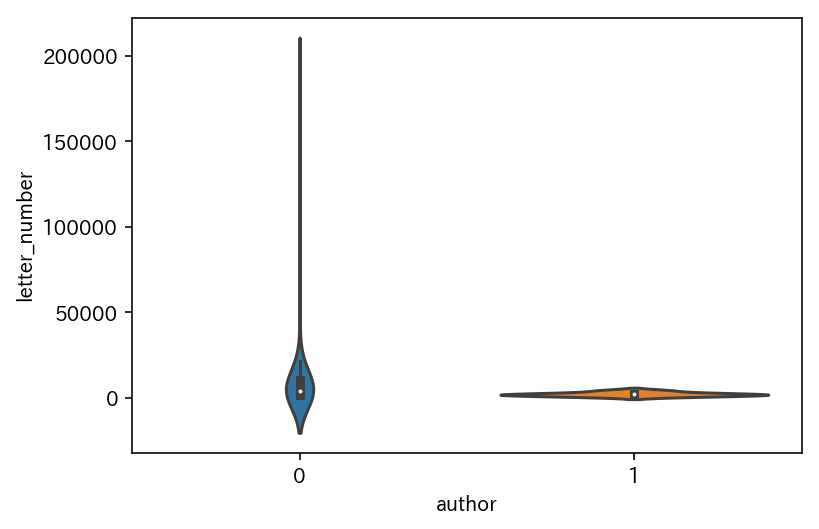

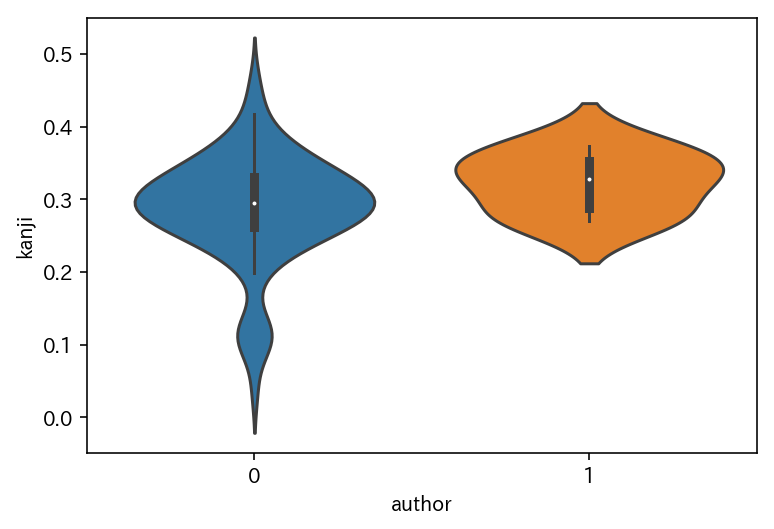

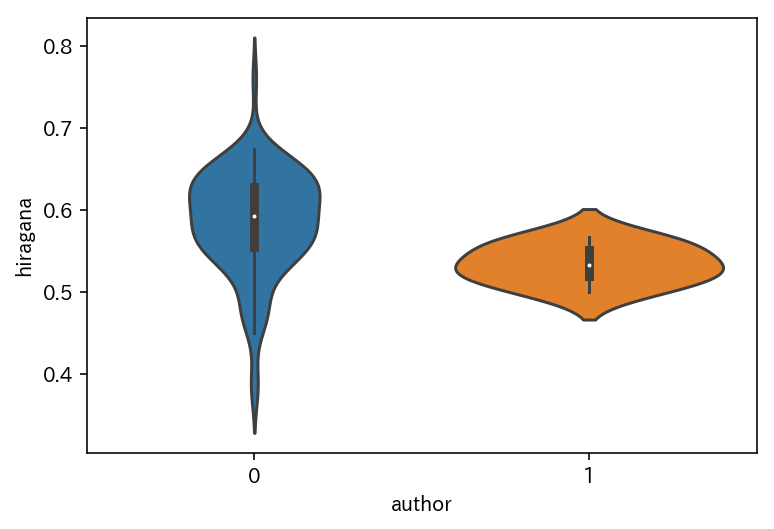

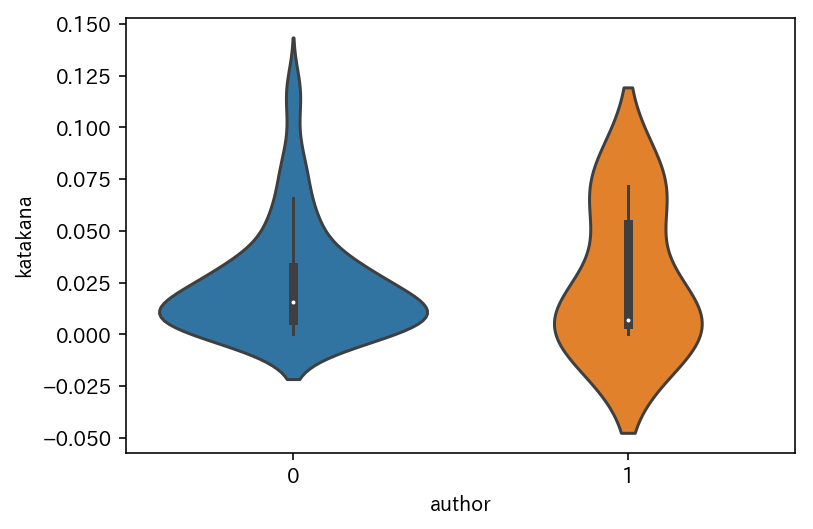

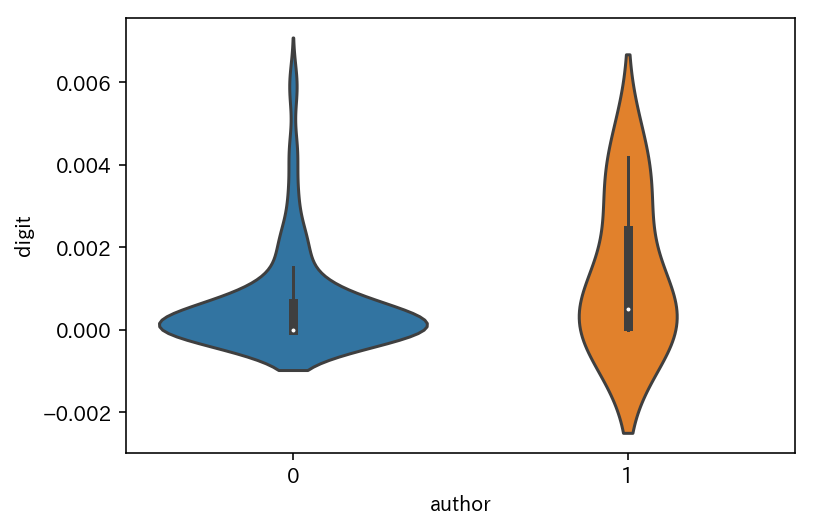

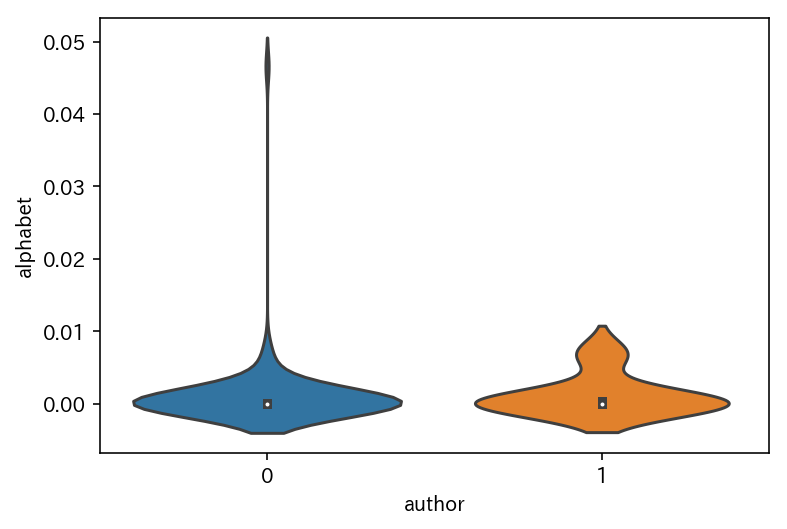

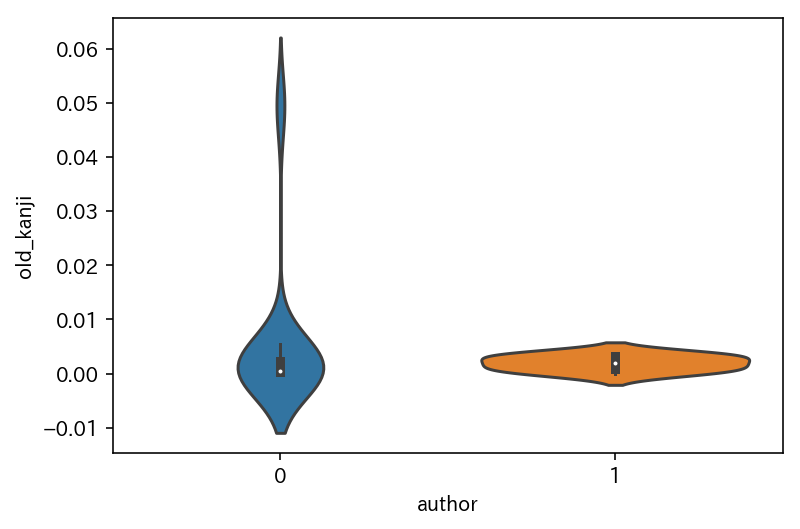

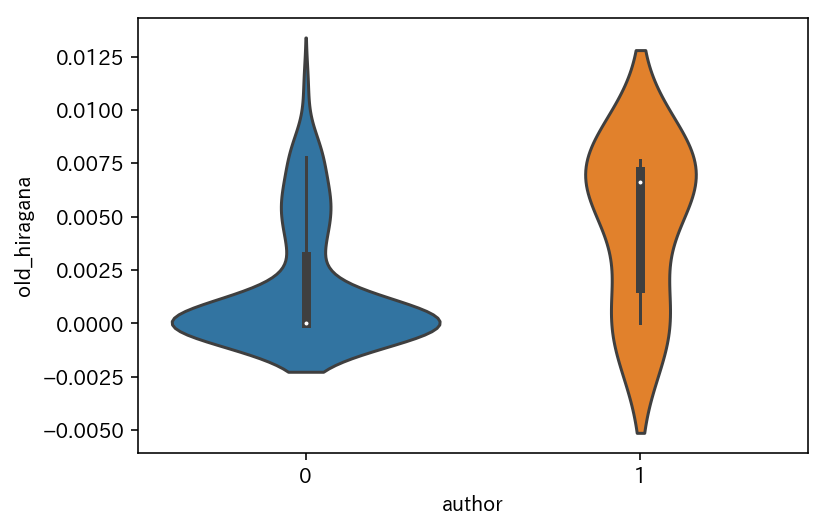

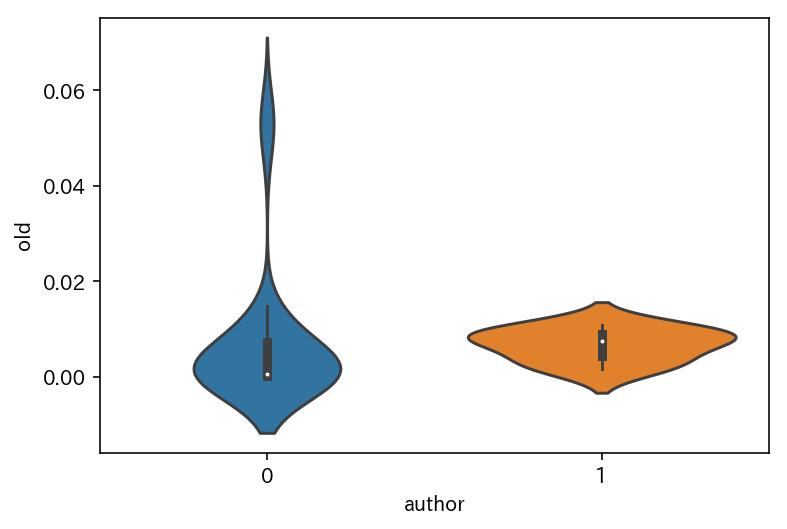

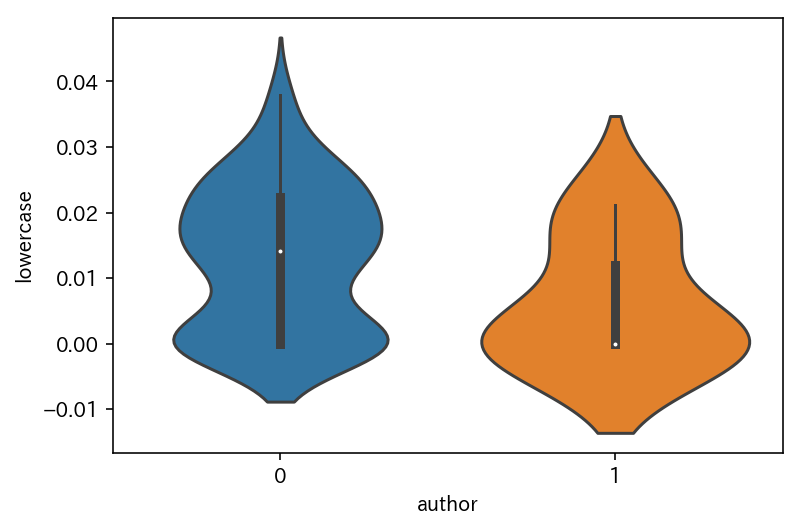

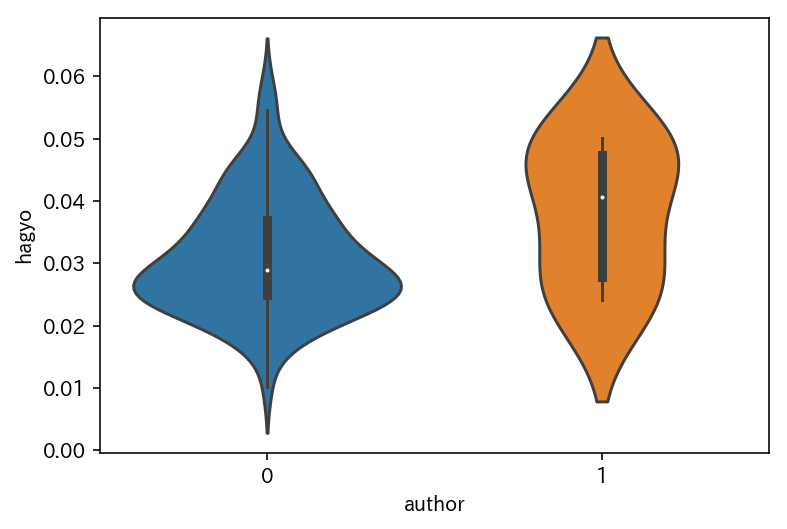

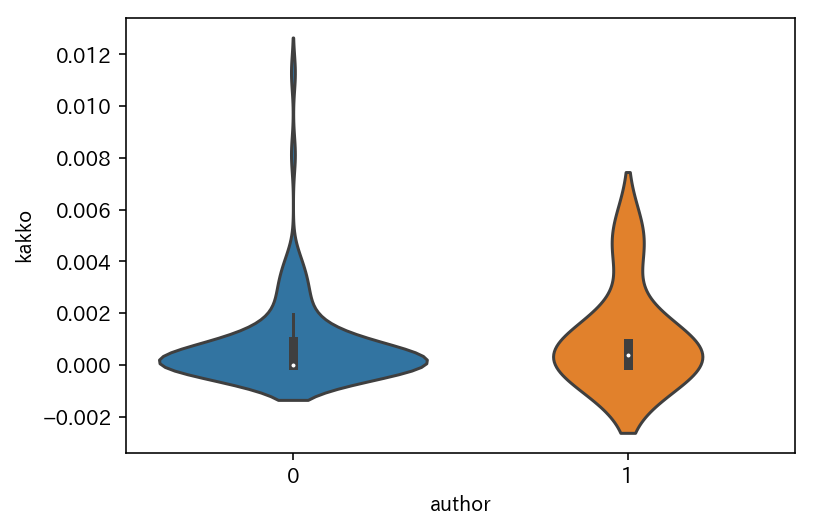

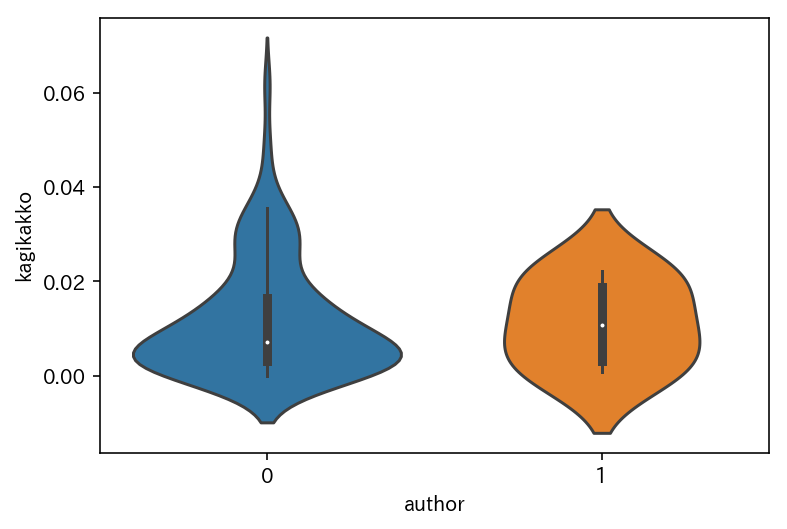

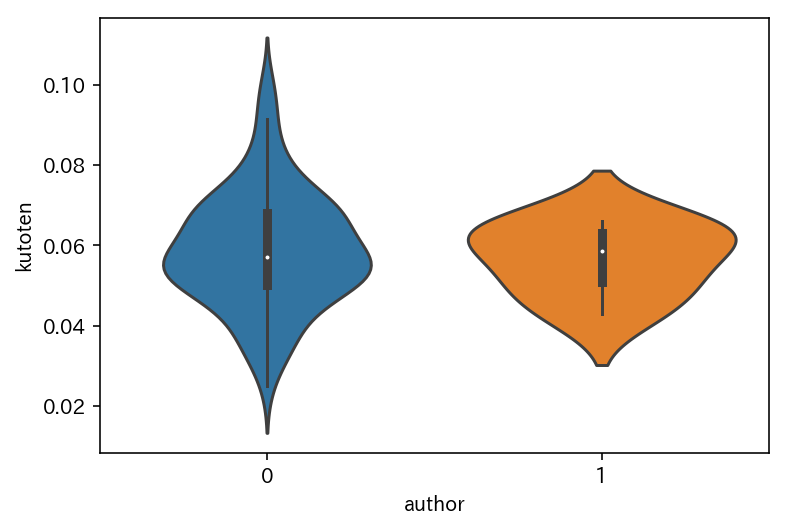

In [23]:
for col in tmp.columns[:-1]:
    sns.violinplot(y=col, x="author", data=tmp)
    plt.title = col
    plt.show()

In [24]:
tmp[tmp["author"]==0].describe()

,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,lowercase,hagyo,kakko,kagikakko,kutoten,author
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.0
mean,10549.574468,0.287236,0.585798,0.025154,0.000648,0.001032,0.005393,0.001654,0.007046,0.012918,0.030995,0.000799,0.011822,0.058839,0.0
std,25596.946537,0.074013,0.062407,0.026801,0.001206,0.004950,0.013588,0.002815,0.014555,0.010962,0.009149,0.001679,0.012294,0.014428,0.0
min,177.000000,0.038356,0.378531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010173,0.000000,0.000000,0.024929,0.0
25%,1542.250000,0.261741,0.554698,0.006708,0.000000,0.000000,0.000206,0.000000,0.000226,0.000000,0.024889,0.000000,0.003072,0.050205,0.0
50%,4020.000000,0.295731,0.592467,0.015802,0.000000,0.000000,0.000559,0.000000,0.000687,0.014146,0.028991,0.000000,0.007138,0.057204,0.0
75%,10494.000000,0.330900,0.628661,0.032780,0.000662,0.000191,0.002337,0.003151,0.007210,0.022323,0.037010,0.000938,0.016380,0.068116,0.0
max,190086.000000,0.463377,0.760274,0.121829,0.006115,0.046566,0.051182,0.011125,0.059365,0.037867,0.058714,0.011299,0.061810,0.100198,0.0


In [25]:
tmp[tmp["author"]==1].describe()

,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,lowercase,hagyo,kakko,kagikakko,kutoten,author
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0
mean,2234.833333,0.322817,0.534280,0.026340,0.001367,0.001227,0.001966,0.004710,0.006676,0.006193,0.038050,0.001076,0.011116,0.056509,1.0
std,1173.522461,0.041996,0.024450,0.034043,0.001785,0.002785,0.001487,0.003671,0.003482,0.009729,0.011592,0.001880,0.009298,0.009026,0.0
min,906.000000,0.270806,0.500617,0.000000,0.000000,0.000000,0.000000,0.000000,0.001537,0.000000,0.024044,0.000000,0.000862,0.042823,1.0
25%,1631.000000,0.288591,0.520110,0.004797,0.000096,0.000000,0.000907,0.001656,0.004430,0.000000,0.027735,0.000000,0.003112,0.050986,1.0
50%,1988.500000,0.328173,0.532394,0.006775,0.000500,0.000000,0.001975,0.006629,0.007496,0.000000,0.040617,0.000384,0.010693,0.058516,1.0
75%,2532.000000,0.352349,0.551004,0.053152,0.002416,0.000349,0.003190,0.007157,0.008878,0.012022,0.047325,0.000839,0.018860,0.063150,1.0
max,4301.000000,0.373945,0.567055,0.071744,0.004185,0.006900,0.003699,0.007673,0.010781,0.021129,0.050022,0.004825,0.022282,0.066031,1.0


In [26]:
hyoki_df["kanji"]+hyoki_df["hiragana"]+hyoki_df["katakana"]+hyoki_df["digit"]+\
hyoki_df["alphabet"]+hyoki_df["old_hiragana"]+hyoki_df["kakko"]+hyoki_df["kagikakko"]+hyoki_df["kutoten"]

0     1.000000
1     1.002935
2     0.997925
3     0.954197
4     0.989469
5     0.957435
6     0.995591
7     0.984476
8     0.953406
9     0.996527
10    0.987987
11    0.986413
12    0.996685
13    0.980917
14    0.993736
15    0.989778
16    0.845365
17    0.995246
18    0.969232
19    0.993011
20    0.994086
21    0.951403
22    0.975561
23    0.963500
24    0.939955
25    0.981092
26    0.990981
27    0.962156
28    0.995062
29    0.831802
        ...   
70    0.998730
71    0.938356
72    0.991438
73    0.990356
74    0.981469
75    0.979145
76    0.832137
77    0.948165
78    0.960080
79    0.997038
80    0.985500
81    0.998896
82    0.976509
83    0.993655
84    0.993415
85    1.001730
86    0.997223
87    0.996153
88    0.991089
89    1.004717
90    0.944513
91    0.996359
92    0.969907
93    0.994071
94    0.830349
95    0.979679
96    0.820236
97    0.962841
98    0.987378
99    0.975077
Length: 100, dtype: float64

## 単語

https://techacademy.jp/magazine/18915
エスケープシーケンス	意味  
\a	ベル  
\b	 バックスペース  
\f	改ページ  
\n	改行  
\r	キャリッジリターン  
\t	水平タブ  
\v	垂直タブ  
\\	「\」そのもの  
\”	「”」ダブルクォーテーション  
\’	「’」シングルクォーテーション  
\nnn	8進数nnnでASCIIコードの文字を指定  
\xhh	16進数nnでASCIIコードの文字を指定  
\uhhhh	16進数hhhhでUnicodeの文字を指定  
\0	NULL  

\r: 復帰。キャレットを左端の位置に戻すこと  
\n: 改行。キャレットを新しい行に移動すること  
\u3000: 全角スペース

In [27]:
train.loc[0, "body"].count("\r\n")

11

In [28]:
train.loc[0, "body"].count("\u3000")

6

In [29]:
train.loc[0, "body"][:30]

'\r\n\u3000先ごろの本欄に僕の「風報」にかいた「天皇陛下に捧ぐる言'

In [30]:
mecab = MeCab.Tagger("-Ochasen")

In [31]:
node = mecab.parseToNode(train.loc[0, "body"][:30])
while node:
    word = node.feature.split(',')
    print(word)
    node = node.next

['BOS/EOS', '*', '*', '*', '*', '*', '*', '*', '*']
['記号', '一般', '*', '*', '*', '*', '*']
['記号', '空白', '*', '*', '*', '*', '\u3000', '\u3000', '\u3000']
['名詞', '副詞可能', '*', '*', '*', '*', '先ごろ', 'サキゴロ', 'サキゴロ']
['助詞', '連体化', '*', '*', '*', '*', 'の', 'ノ', 'ノ']
['名詞', '一般', '*', '*', '*', '*', '本欄', 'ホンラン', 'ホンラン']
['助詞', '格助詞', '一般', '*', '*', '*', 'に', 'ニ', 'ニ']
['名詞', '代名詞', '一般', '*', '*', '*', '僕', 'ボク', 'ボク']
['助詞', '連体化', '*', '*', '*', '*', 'の', 'ノ', 'ノ']
['記号', '括弧開', '*', '*', '*', '*', '「', '「', '「']
['名詞', '一般', '*', '*', '*', '*', '風', 'カゼ', 'カゼ']
['名詞', '接尾', '一般', '*', '*', '*', '報', 'ホウ', 'ホー']
['記号', '括弧閉', '*', '*', '*', '*', '」', '」', '」']
['助詞', '格助詞', '一般', '*', '*', '*', 'に', 'ニ', 'ニ']
['動詞', '自立', '*', '*', '五段・カ行イ音便', '連用タ接続', 'かく', 'カイ', 'カイ']
['助動詞', '*', '*', '*', '特殊・タ', '基本形', 'た', 'タ', 'タ']
['記号', '括弧開', '*', '*', '*', '*', '「', '「', '「']
['名詞', '一般', '*', '*', '*', '*', '天皇陛下', 'テンノウヘイカ', 'テンノーヘイカ']
['助詞', '格助詞', '一般', '*', '*', '*', 'に', 'ニ', 'ニ']
['動詞', '

In [32]:
# def hyoki(bodies):
#     df = pd.DataFrame(columns=["letter_number", "kanji", "hiragana", "katakana", "digit",
#                                "alphabet", "old_kanji", "old_hiragana", "old", "lowercase",
#                                "hagyo", "kakko", "kagikakko", "kutoten"])
#     for i, body in enumerate(bodies):
#         body = body.replace("\u3000", "").strip().replace("\r\n", "").strip()
#         df.loc[i, "kanji"] = len(re.findall("[\u4E00-\u9FD0]", repr(body)))/len(body)
#         df.loc[i, "hiragana"] = len(re.findall('[ぁ-ゟ]', repr(body)))/len(body)
#         df.loc[i, "katakana"] = (len(re.findall('[\ァ-ヿ]', repr(body)))+len(re.findall('[ｦ-ﾟ]', repr(body))))/len(body)
#         df.loc[i, "digit"] = len(re.findall('\d', repr(body)))/len(body)
#         df.loc[i, "alphabet"] = len(re.findall('[a-zA-Zａ-ｚＡ-Ｚ]', repr(body)))/len(body)
#         df.loc[i, "old_kanji"] = sum([len(re.findall(s, repr(body))) for s in old_kanji])/len(body)
#         df.loc[i, "old_hiragana"] = sum([len(re.findall(s, repr(body))) for s in old_kana])/len(body)
#         df.loc[i, "old"] = df.loc[i, "old_kanji"]+df.loc[i, "old_hiragana"]
#         df.loc[i, "lowercase"] = sum([len(re.findall(s, repr(body))) for s in komoji])/len(body)
#         df.loc[i, "hagyo"] = sum([len(re.findall(s, repr(body))) for s in hagyo])/len(body)
#         df.loc[i, "kakko"] = len(re.findall('[（-）]', repr(body)))/len(body)
#         df.loc[i, "kagikakko"] = len(re.findall('[「-」]', repr(body)))/len(body)
#         df.loc[i, "kutoten"] = len(re.findall('[、-。]', repr(body)))/len(body)
#         df.loc[i, "letter_number"] = len(body)
#     return df

In [33]:
def word(bodies):
    word_list = []
    for body in bodies:
        node = mecab.parseToNode(body)
        words = []
        while node:
            words.append(node.feature.split(',')[6])
            node = node.next
        word_list.append(words)
    return word_list

In [34]:
word_list = word(train["body"][:num_sample])

In [35]:
len(word_list)

100

In [36]:
from itertools import chain

In [37]:
# pd.Series(list(chain.from_iterable(word_list))).value_counts()[:10]

In [38]:
def keyword(word_list, num_keyword):
    colmns = pd.Series(list(chain.from_iterable(word_list))).value_counts()[:num_keyword].index
    df = pd.DataFrame(index=range(num_sample), columns=colmns)
    for i, word in enumerate(word_list):
        tmp = pd.Series(word_list[i]).value_counts()
        for j in range(len(tmp)):
            col = tmp.index[j]
            val = tmp.values[j]/len(word)
            try:
                df.loc[i, col] = val
            except:
                pass
    df = df.replace(np.nan, 0.0)
    return df

In [39]:
word_df = keyword(word_list, 100)

In [40]:
word_df

,、,の,*,。,に,は,た,て,を,だ,...,すり抜ける,父方,思いのたけ,小綺麗,遽しい,どくどく,樹下,銅,初孫,勝味
0,0.056075,0.065421,0.037383,0.032710,0.046729,0.023364,0.011682,0.014019,0.035047,0.039720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.094258,0.059588,0.018418,0.021668,0.043337,0.030336,0.018418,0.018418,0.027086,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.046875,0.056250,0.031250,0.025000,0.018750,0.021875,0.046875,0.050000,0.034375,0.015625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.052599,0.052908,0.047339,0.035272,0.036510,0.030012,0.041460,0.019493,0.037438,0.008973,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.043084,0.070619,0.025915,0.045028,0.047295,0.032070,0.051830,0.031422,0.030126,0.017817,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.060456,0.047985,0.048233,0.021143,0.026429,0.025603,0.027750,0.026181,0.025190,0.015031,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.050351,0.068501,0.016979,0.022834,0.028689,0.025761,0.029859,0.033958,0.026932,0.038056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.047079,0.040839,0.040839,0.034600,0.032898,0.045944,0.028928,0.014748,0.017584,0.017584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.049034,0.041833,0.090296,0.021717,0.026174,0.028918,0.023088,0.018174,0.020117,0.015087,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.047862,0.061183,0.040273,0.035936,0.034077,0.033302,0.030204,0.032683,0.023544,0.035006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
word_df.sum(axis=1)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
     ... 
70    1.0
71    1.0
72    1.0
73    1.0
74    1.0
75    1.0
76    1.0
77    1.0
78    1.0
79    1.0
80    1.0
81    1.0
82    1.0
83    1.0
84    1.0
85    1.0
86    1.0
87    1.0
88    1.0
89    1.0
90    1.0
91    1.0
92    1.0
93    1.0
94    1.0
95    1.0
96    1.0
97    1.0
98    1.0
99    1.0
Length: 100, dtype: float64

In [42]:
word_df.sum().sum()

99.99999999999999

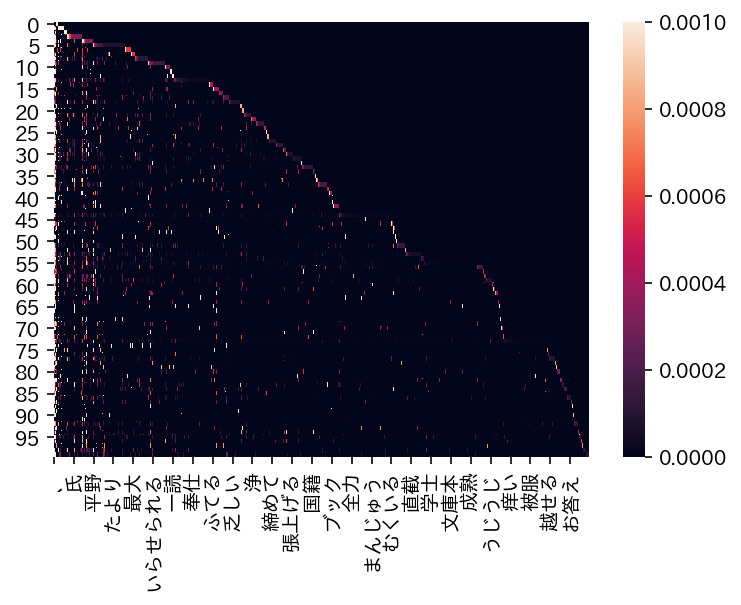

In [43]:
sns.heatmap(word_df, vmax=0.001)

## 品詞

In [44]:
adjective0_list = []
# adjective1_list = []
# adjective2_list = []
adjective01_list = []
adjective012_list = []
katsuyo0_list = []
# katsuyo1_list = []
katsuyo01_list = []
for body in train["body"][:num_sample]:
    node = mecab.parseToNode(body)
    adjective0 = []
#     adjective1 = []
#     adjective2 = []
    adjective01 = []
    adjective012 = []
    katsuyo0 = []
#     katsuyo1 = []
    katsuyo01 = []
    while node:
        adjective0.append(node.feature.split(',')[0])
#         adjective1.append(node.feature.split(',')[1])
#         adjective2.append(node.feature.split(',')[2])
        adjective01.append(node.feature.split(',')[0]+node.feature.split(',')[1])
        adjective012.append(node.feature.split(',')[0]+node.feature.split(',')[1]+node.feature.split(',')[2])
        katsuyo0.append(node.feature.split(',')[4])
#         katsuyo1.append(node.feature.split(',')[5])
        katsuyo01.append(node.feature.split(',')[4]+node.feature.split(',')[5])
        node = node.next
    adjective0_list.append(adjective0)
#     adjective1_list.append(adjective1)
#     adjective2_list.append(adjective2)
    adjective01_list.append(adjective01)
    adjective012_list.append(adjective012)
    katsuyo0_list.append(katsuyo0)
#     katsuyo1_list.append(katsuyo1)
    katsuyo01_list.append(katsuyo01)

In [45]:
pd.Series(list(chain.from_iterable(adjective0_list))).value_counts()[:10]

名詞     196621
助詞     172358
記号     128906
動詞      81196
助動詞     64472
副詞      16062
形容詞     10955
連体詞      6858
接続詞      4671
接頭詞      4630
dtype: int64

In [46]:
pd.Series(list(chain.from_iterable(adjective01_list))).value_counts()[:10]

名詞一般      90676
助詞格助詞     70269
動詞自立      66867
助動詞*      64472
記号読点      39851
助詞接続助詞    28090
助詞係助詞     27248
助詞連体化     25153
記号句点      24392
名詞非自立     22466
dtype: int64

In [47]:
pd.Series(list(chain.from_iterable(adjective012_list))).value_counts()[:10]

名詞一般*      90676
動詞自立*      66867
助動詞**      64472
助詞格助詞一般    60536
記号読点*      39851
助詞接続助詞*    28090
助詞係助詞*     27248
助詞連体化*     25153
記号句点*      24392
記号一般*      22308
dtype: int64

In [48]:
pd.Series(list(chain.from_iterable(katsuyo0_list))).value_counts()[:10]

*           533218
一段           28269
特殊・タ         20189
五段・ラ行        16624
特殊・ダ         14750
サ変・スル         9526
形容詞・アウオ段      8401
特殊・マス         5749
五段・ワ行促音便      5694
特殊・ナイ         5522
dtype: int64

In [49]:
pd.Series(list(chain.from_iterable(katsuyo01_list))).value_counts()[:10]

**            533218
特殊・タ基本形        19372
一段連用形          17309
一段基本形           7236
サ変・スル連用形        5806
不変化型基本形         5312
五段・ラ行連用タ接続      4616
特殊・ダ体言接続        4467
特殊・ダ基本形         4420
特殊・ダ連用形         4378
dtype: int64

In [50]:
def hinshi(hinshi_list):
    colmns = pd.Series(list(chain.from_iterable(hinshi_list))).value_counts().index
    df = pd.DataFrame(index=range(num_sample), columns=colmns)
    for i, hinshi in enumerate(hinshi_list):
        tmp = pd.Series(hinshi_list[i]).value_counts()
        for j in range(len(tmp)):
            col = tmp.index[j]
            val = tmp.values[j]/len(hinshi)
            try:
                df.loc[i, col] = val
            except:
                pass
    df = df.replace(np.nan, 0.0)
    return df

In [51]:
adjective0_df = hinshi(adjective0_list)

In [52]:
adjective0_df

,名詞,助詞,記号,動詞,助動詞,副詞,形容詞,連体詞,接続詞,接頭詞,感動詞,フィラー,BOS/EOS,その他
0,0.282710,0.273364,0.149533,0.121495,0.102804,0.016355,0.018692,0.014019,0.007009,0.000000,0.000000,0.009346,0.004673,0.000000
1,0.306609,0.293608,0.141928,0.100758,0.074756,0.019502,0.018418,0.019502,0.007584,0.011918,0.002167,0.001083,0.002167,0.000000
2,0.300000,0.271875,0.115625,0.156250,0.096875,0.021875,0.012500,0.012500,0.003125,0.003125,0.000000,0.000000,0.006250,0.000000
3,0.321163,0.249381,0.189666,0.101176,0.071782,0.019183,0.020730,0.009592,0.005569,0.007116,0.002785,0.001238,0.000619,0.000000
4,0.278264,0.292193,0.136378,0.131195,0.091675,0.017493,0.021056,0.012634,0.014577,0.002915,0.000972,0.000000,0.000648,0.000000
5,0.281797,0.238520,0.220020,0.114718,0.089693,0.021308,0.010737,0.007185,0.003964,0.008672,0.002230,0.000661,0.000165,0.000330
6,0.305621,0.295667,0.097190,0.134660,0.100703,0.016393,0.027518,0.014637,0.004684,0.001756,0.000000,0.000000,0.001171,0.000000
7,0.287578,0.220079,0.226319,0.098695,0.114577,0.014748,0.007941,0.011344,0.007941,0.004538,0.002836,0.002269,0.001134,0.000000
8,0.312836,0.224940,0.215796,0.107555,0.089496,0.011887,0.011773,0.008572,0.003315,0.009944,0.002400,0.001143,0.000229,0.000114
9,0.319703,0.277416,0.131196,0.113848,0.101146,0.018897,0.015489,0.008829,0.004957,0.006970,0.001239,0.000000,0.000310,0.000000


In [53]:
adjective0_df.sum(axis=1)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
     ... 
70    1.0
71    1.0
72    1.0
73    1.0
74    1.0
75    1.0
76    1.0
77    1.0
78    1.0
79    1.0
80    1.0
81    1.0
82    1.0
83    1.0
84    1.0
85    1.0
86    1.0
87    1.0
88    1.0
89    1.0
90    1.0
91    1.0
92    1.0
93    1.0
94    1.0
95    1.0
96    1.0
97    1.0
98    1.0
99    1.0
Length: 100, dtype: float64

In [54]:
adjective0_df.sum().sum()

100.00000000000001

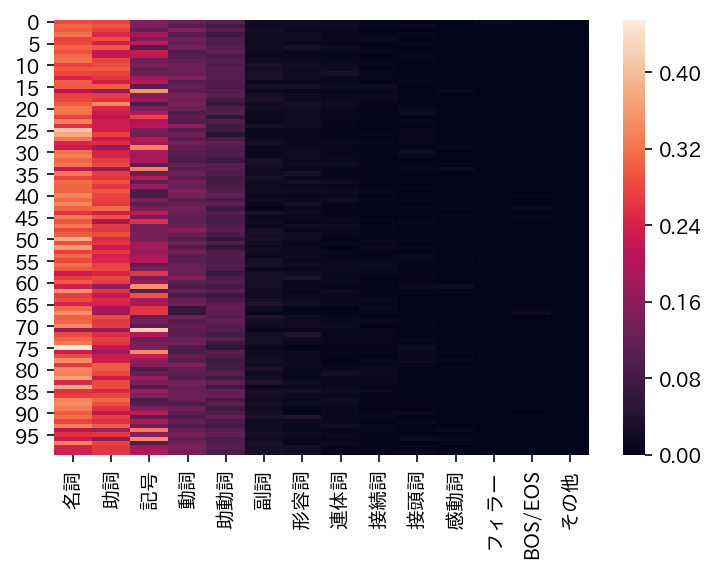

In [55]:
sns.heatmap(adjective0_df)

In [56]:
adjective0_df = hinshi(adjective0_list)
# adjective1_df = hinshi(adjective1_list)
# adjective2_df = hinshi(adjective2_list)
adjective01_df = hinshi(adjective01_list)
adjective012_df = hinshi(adjective012_list)
katsuyo0_df = hinshi(katsuyo0_list)
# katsuyo1_df = hinshi(katsuyo1_list)
katsuyo01_df = hinshi(katsuyo01_list)

In [57]:
adjective012_df

,名詞一般*,動詞自立*,助動詞**,助詞格助詞一般,記号読点*,助詞接続助詞*,助詞係助詞*,助詞連体化*,記号句点*,記号一般*,...,その他間投*,形容詞接尾*,記号アルファベット*,名詞接尾サ変接続,名詞動詞非自立的*,接頭詞動詞接続*,名詞接続詞的*,助詞特殊*,名詞代名詞縮約,接頭詞形容詞接続*
0,0.130841,0.098131,0.102804,0.116822,0.056075,0.030374,0.051402,0.051402,0.032710,0.028037,...,0.000000,0.002336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.156013,0.091008,0.074756,0.110509,0.094258,0.033586,0.041170,0.052004,0.021668,0.007584,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.153125,0.103125,0.096875,0.103125,0.046875,0.062500,0.025000,0.043750,0.025000,0.025000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.178218,0.091894,0.071782,0.109220,0.052599,0.031869,0.034653,0.048886,0.035272,0.028465,...,0.000000,0.000000,0.000000,0.000000,0.000309,0.000619,0.000000,0.000000,0.000000,0.000000
4,0.153871,0.101717,0.091675,0.116618,0.043084,0.045675,0.039521,0.063168,0.045028,0.022352,...,0.000000,0.000000,0.000648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.130657,0.092501,0.089693,0.080360,0.060456,0.041625,0.037909,0.037000,0.021143,0.044599,...,0.000330,0.000083,0.000000,0.000000,0.000083,0.000165,0.000000,0.000165,0.000000,0.000000
6,0.127635,0.100117,0.100703,0.101288,0.050351,0.051522,0.038642,0.051522,0.022834,0.011710,...,0.000000,0.000000,0.000000,0.000585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.112309,0.085082,0.114577,0.081679,0.047079,0.022121,0.050482,0.028361,0.034600,0.036869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000567
8,0.173391,0.095897,0.089496,0.076809,0.049034,0.031546,0.042519,0.031204,0.021717,0.045377,...,0.000114,0.000457,0.000000,0.000000,0.000000,0.000114,0.000000,0.000229,0.000000,0.000000
9,0.138321,0.093866,0.101146,0.096809,0.047862,0.052509,0.046468,0.043371,0.035936,0.019052,...,0.000000,0.000155,0.000620,0.000000,0.000620,0.000000,0.001084,0.000000,0.000000,0.000000


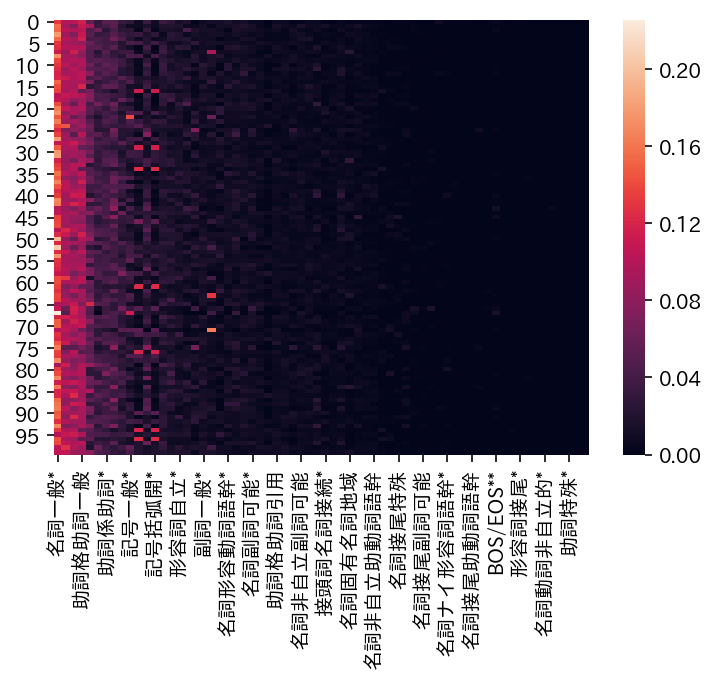

In [58]:
sns.heatmap(adjective012_df)

## ネガポジ

In [59]:
negaposi_dict_df = pd.read_csv("../input/pn_ja.dic.csv", sep=":", encoding="shift-jis", header=None, index_col=0)

In [60]:
negaposi_dict_df = negaposi_dict_df.rename(columns={1: "pronunciation", 2: "adjective", 3: "score"})
negaposi_dict_df

,pronunciation,adjective,score
0,,,
優れる,すぐれる,動詞,1.000000
良い,よい,形容詞,0.999995
喜ぶ,よろこぶ,動詞,0.999979
褒める,ほめる,動詞,0.999979
めでたい,めでたい,形容詞,0.999645
賢い,かしこい,形容詞,0.999486
善い,いい,形容詞,0.999314
適す,てきす,動詞,0.999295
天晴,あっぱれ,名詞,0.999267


In [61]:
negaposi_dict = negaposi_dict_df["score"].to_dict()

In [62]:
tmp = pd.concat([pd.Series(word_list[0]).map(negaposi_dict), pd.Series(word_list[0])], axis=1)
tmp

,0,1
0,NaN,*
1,NaN,*
2,NaN,
3,NaN,先ごろ
4,NaN,の
5,NaN,本欄
6,NaN,に
7,NaN,僕
8,NaN,の
9,NaN,「


In [63]:
pd.Series(word_list[0]).map(negaposi_dict).sum()

-63.866304

In [64]:
negaposi_dict

{'優れる': 1.0,
 '良い': 0.9999950000000001,
 '喜ぶ': 0.9999790000000001,
 '褒める': 0.9999790000000001,
 'めでたい': 0.9996450000000001,
 '賢い': 0.9994860000000001,
 '善い': 0.9993139999999999,
 '適す': 0.999295,
 '天晴': 0.999267,
 '祝う': 0.999122,
 '功績': 0.9991040000000001,
 '賞': 0.998943,
 '嬉しい': 0.998871,
 '喜び': 0.9988610000000001,
 '才知': 0.998771,
 '徳': 0.9987450000000001,
 '才能': 0.998699,
 '素晴らしい': 0.998617,
 '芳しい': 0.9985780000000001,
 '称える': 0.998576,
 '適切': 0.9984059999999999,
 '崇める': 0.9983569999999999,
 '助ける': 0.9907020000000001,
 '抜きんでる': 0.9983559999999999,
 '清水': 0.98213,
 '雄雄しい': 0.9982719999999999,
 '仕合せ': 0.998208,
 '幸い': 0.997862,
 '吉兆': 0.9977950000000001,
 '秀でる': 0.997777,
 '宜しい': 0.997517,
 'きりりしゃんと': 0.997511,
 '矜持': 0.9889459999999999,
 '香しい': 0.9974379999999999,
 'しこなす': 0.997408,
 '遣りこなす': 0.9974059999999999,
 '優麗': 0.997337,
 '気高い': 0.997325,
 '手柄': 0.997308,
 '正義': 0.9972780000000001,
 '麗しい': 0.99726,
 '名高い': 0.997259,
 '感心': 0.997201,
 '誉れ': 0.9971979999999999,
 '卓説': 0.997194,


In [65]:
len(tmp)

428

In [66]:
len(tmp.dropna())

115

In [67]:
tmp[tmp[0]>0]

,0,1
67,0.969919,愛情
92,0.222109,頃日
120,0.967772,識見
160,0.993836,正しい
320,0.936944,育てる
354,0.969919,愛情


In [68]:
def negaposi(word_list):
    columns = ["negaposi_0", "negaposi_1", "negaposi_2", "negaposi_3", "negaposi_mean", "negaposi_std"]
    negaposi_df = pd.DataFrame(index=range(len(word_list)), columns=columns)
    for i, word in enumerate(word_list):
        score = pd.Series(word).map(negaposi_dict).replace({np.nan: 0.0})
        for j in range(4):
            score_quarter = score[int(len(score)/4*j): int(len(score)/4*(j+1))]
            negaposi_df.loc[i, f"negaposi_{j}".format(j)] = score_quarter.sum()/len(score_quarter)
    negaposi_df["negaposi_mean"] = negaposi_df.drop(columns=["negaposi_mean", "negaposi_std"]).mean(axis=1)
    negaposi_df["negaposi_std"] = negaposi_df.drop(columns=["negaposi_mean", "negaposi_std"]).std(axis=1)
    for j in range(4):
        negaposi_df[f"negaposi_{j}".format(j)] = negaposi_df[f"negaposi_{j}".format(j)]-negaposi_df["negaposi_mean"]
    negaposi_df = negaposi_df.astype(float)
    
    return negaposi_df

In [69]:
negaposi_df = negaposi(word_list[:num_sample])
# negaposi_df = negaposi(word_list[:3])

In [70]:
negaposi_df

,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
0,-0.008959,-0.026133,0.001534,0.033558,-0.149220,0.025111
1,-0.001320,-0.051084,0.027209,0.025195,-0.133101,0.036453
2,-0.006494,0.000760,-0.021711,0.027444,-0.190386,0.020553
3,-0.005741,0.004553,0.010287,-0.009100,-0.174365,0.008987
4,-0.024023,0.023435,-0.005564,0.006152,-0.176879,0.019959
5,0.002984,0.001738,-0.004676,-0.000046,-0.155715,0.003356
6,-0.012257,-0.003049,0.013151,0.002154,-0.144991,0.010601
7,-0.006974,-0.017298,0.041292,-0.017020,-0.110433,0.027944
8,0.007921,-0.009098,0.009120,-0.007944,-0.130927,0.009862
9,-0.019600,0.001547,0.000193,0.017860,-0.135904,0.015336


In [71]:
negaposi_df.mean()

negaposi_0      -0.001819
negaposi_1       0.001175
negaposi_2       0.000385
negaposi_3       0.000258
negaposi_mean   -0.144214
negaposi_std     0.017809
dtype: float64

In [72]:
negaposi_df.describe()

,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.001819,0.001175,0.000385,0.000258,-0.144214,0.017809
std,0.016942,0.018685,0.019991,0.020428,0.031136,0.012871
min,-0.057749,-0.052858,-0.083984,-0.088836,-0.222233,0.001337
25%,-0.011767,-0.008702,-0.009124,-0.010027,-0.162846,0.009182
50%,-0.001022,0.001562,0.001732,-0.001854,-0.146714,0.014419
75%,0.007693,0.009308,0.010580,0.011152,-0.132422,0.022618
max,0.046559,0.065025,0.051182,0.061022,-0.042688,0.071854


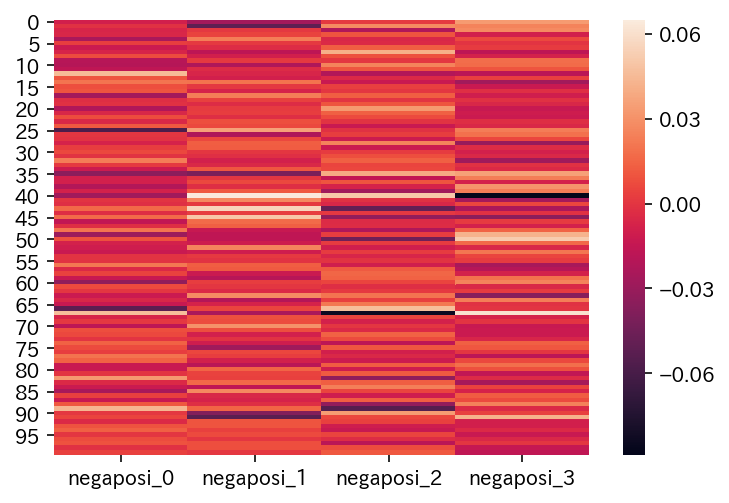

In [73]:
sns.heatmap(negaposi_df.drop(columns=["negaposi_mean", "negaposi_std"]))

## 可視化

In [74]:
tmp = pd.concat([
    train["author"][:num_sample],
    hyoki_df,
#     word_df,
    adjective0_df,
#     adjective1_df,
#     adjective2_df,
    adjective01_df,
    adjective012_df,
    katsuyo0_df,
#     katsuyo1_df,
    katsuyo01_df,
    negaposi_df],
    axis=1)
tmp

,author,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,...,下二・ガ行体言接続,特殊・タイ文語基本形,五段・ワ行ウ音便未然形,五段・ワ行ウ音便基本形,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
0,0,651.0,0.298003,0.594470,0.036866,0.000000,0.000000,0.001536,0.000000,0.001536,...,0.002336,0.000000,0.000000,0.0,-0.008959,-0.026133,0.001534,0.033558,-0.149220,0.025111
1,0,1363.0,0.319883,0.562729,0.026412,0.000000,0.000000,0.000000,0.005136,0.005136,...,0.000000,0.000000,0.000000,0.0,-0.001320,-0.051084,0.027209,0.025195,-0.133101,0.036453
2,0,482.0,0.338174,0.556017,0.051867,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,-0.006494,0.000760,-0.021711,0.027444,-0.190386,0.020553
3,1,4301.0,0.332946,0.526157,0.004185,0.004185,0.000465,0.000698,0.007673,0.008370,...,0.000000,0.000000,0.000000,0.0,-0.005741,0.004553,0.010287,-0.009100,-0.174365,0.008987
4,0,4273.0,0.334659,0.578750,0.001170,0.000000,0.000468,0.000468,0.000000,0.000468,...,0.000000,0.000000,0.000000,0.0,-0.024023,0.023435,-0.005564,0.006152,-0.176879,0.019959
5,0,16845.0,0.287029,0.557673,0.022737,0.000594,0.001306,0.000712,0.000000,0.000712,...,0.000000,0.000000,0.000000,0.0,0.002984,0.001738,-0.004676,-0.000046,-0.155715,0.003356
6,0,2722.0,0.273328,0.666789,0.008817,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,-0.012257,-0.003049,0.013151,0.002154,-0.144991,0.010601
7,1,2319.0,0.270806,0.567055,0.068564,0.000000,0.006900,0.003450,0.007331,0.010781,...,0.000000,0.000000,0.000000,0.0,-0.006974,-0.017298,0.041292,-0.017020,-0.110433,0.027944
8,0,11568.0,0.295816,0.552472,0.016425,0.001037,0.000000,0.049101,0.002334,0.051435,...,0.000000,0.000000,0.000000,0.0,0.007921,-0.009098,0.009120,-0.007944,-0.130927,0.009862
9,0,9791.0,0.279542,0.582065,0.071903,0.000000,0.000409,0.000204,0.000000,0.000204,...,0.000000,0.000000,0.000000,0.0,-0.019600,0.001547,0.000193,0.017860,-0.135904,0.015336


In [75]:
tmp.isna().sum().sum()

0

In [76]:
tmp["author"].value_counts()

0    94
1     6
Name: author, dtype: int64

In [77]:
from scipy.stats import zscore

In [78]:
tmp.iloc[:, 1:] = tmp.iloc[:, 1:].apply(zscore, axis=0)

In [91]:
diff = pd.Series(tmp[tmp["author"]==0].mean()-tmp[tmp["author"]==1].mean(), name="val").map(abs).sort_values(ascending=False)

In [92]:
diff

五段・ラ行体言接続特殊      2.204405
サ変・−スル未然形        1.719238
特殊・ヤ基本形          1.685078
特殊・ヤ             1.683233
サ変・−スル仮定形        1.675063
下二・タ行未然形         1.675063
文語・ケリ基本形         1.642192
サ変・−ズル文語基本形      1.639493
文語・ケリ            1.615645
文語・ナリ            1.542395
文語・ナリ未然形         1.450590
接頭詞形容詞接続         1.384843
接頭詞形容詞接続*        1.384843
五段・ラ行特殊基本形       1.336045
文語・ル連用形          1.313163
五段・ラ行アル未然形       1.221183
サ変・−スル未然ウ接続      1.197331
五段・バ行基本形         1.195408
助詞接続助詞           1.145208
助詞接続助詞*          1.145208
文語・ナリ体言接続        1.141244
特殊・ダ体言接続         1.056122
五段・カ行イ音便命令ｅ      1.054152
名詞接尾地域           1.049939
old_hiragana     1.044004
名詞接尾副詞可能         1.033900
五段・バ行            1.013496
特殊・ナイガル接続        1.011324
author           1.000000
特殊・ダ             0.922683
                   ...   
サ変・スル未然形         0.046205
katakana         0.044016
サ変・−スル未然レル接続     0.042037
alphabet         0.040628
五段・サ行基本形         0.037026
サ変・−スル文語基本形      0.035621
negaposi_std     0.035264
五段・カ行イ音便仮定形 

In [83]:
sum(pd.Series(tmp[tmp["author"]==0].mean()-tmp[tmp["author"]==1].mean(), name="val").map(abs) > 1)

28

In [98]:
diff["接頭詞形容詞接続"]

1.384843129516496

-2.204405419514308
0.5470939065553089 2.9918881526193664


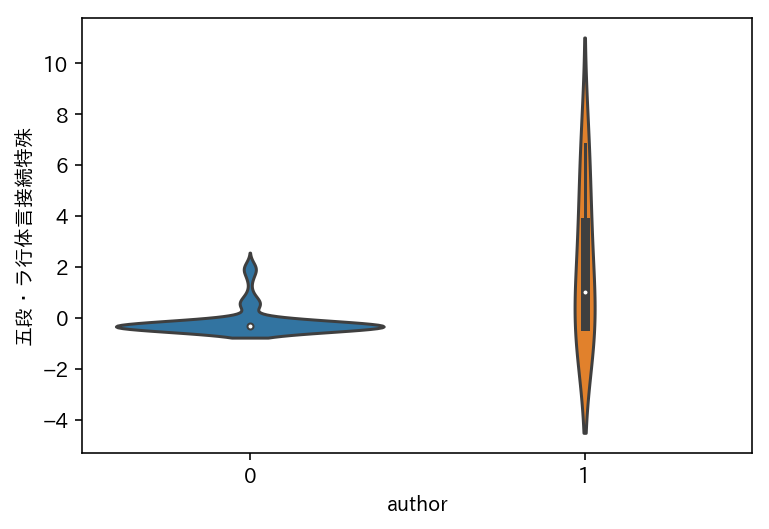

-1.719238149156057
0.6130017735556287 3.1107131862074793


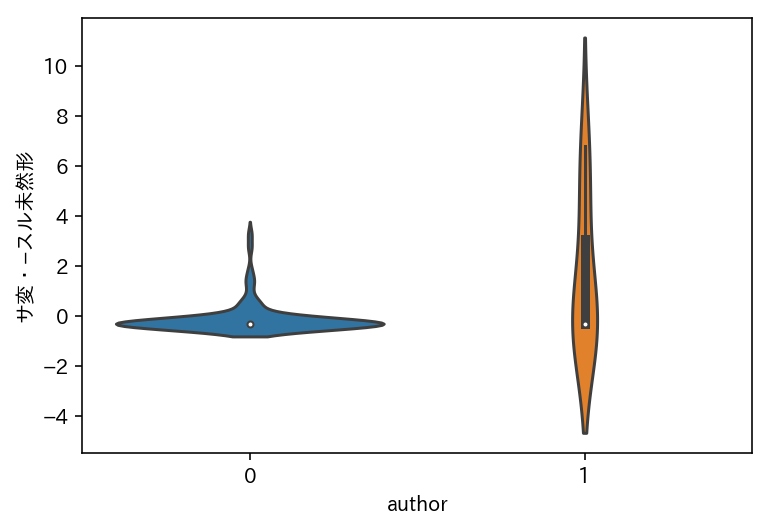

-1.6850780703206312
0.8133654459933155 2.119428963953029


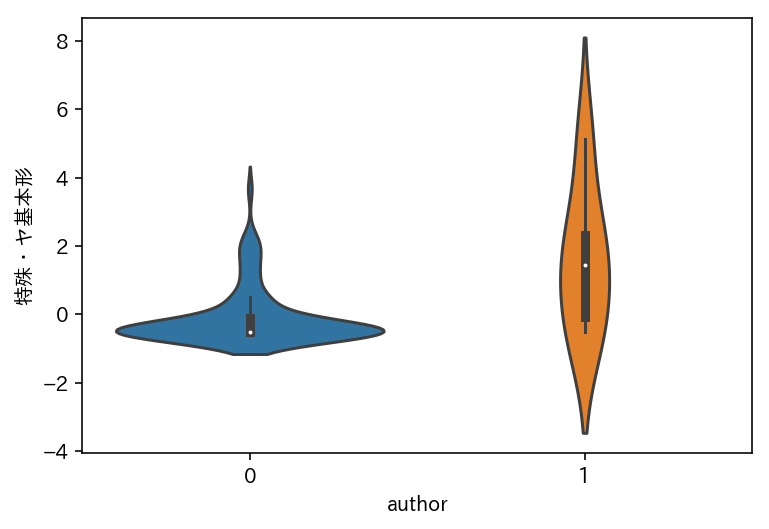

-1.6832327402631393
0.8137345907628447 2.1184472052194034


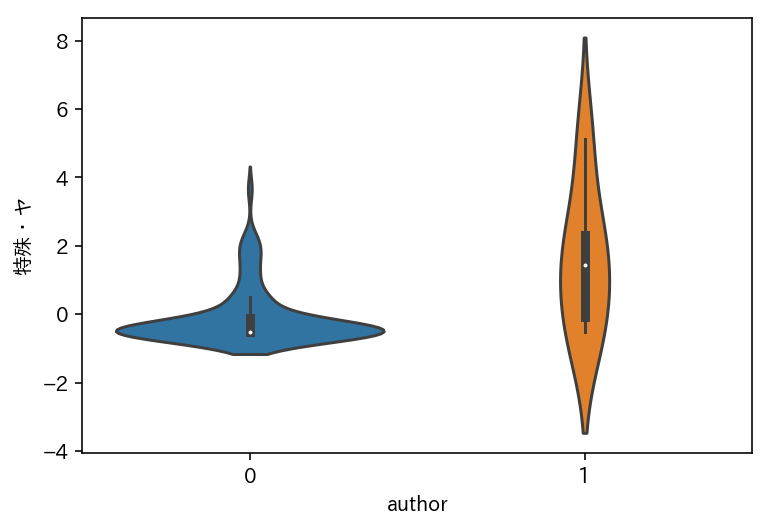

-1.6750630254320207
9.76654005047341e-17 4.103049699311093


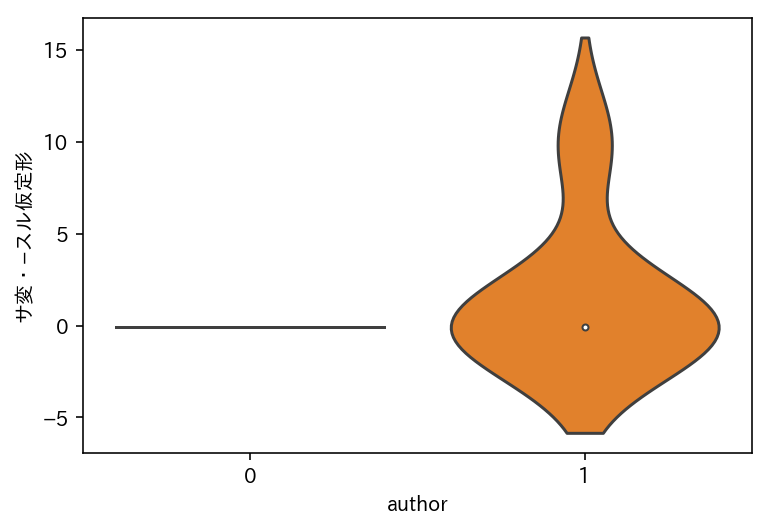

-1.67506302543202
8.371320043262923e-17 4.10304969931109


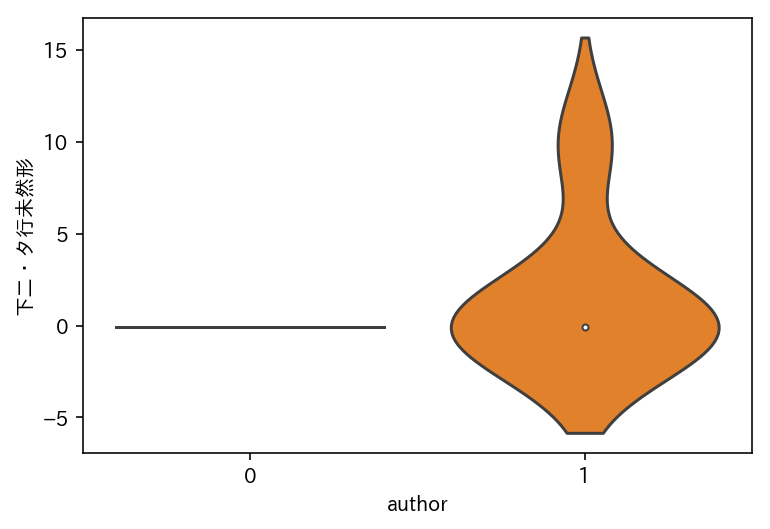

-1.642192108923825
0.14903486799826465 4.0675402196339485


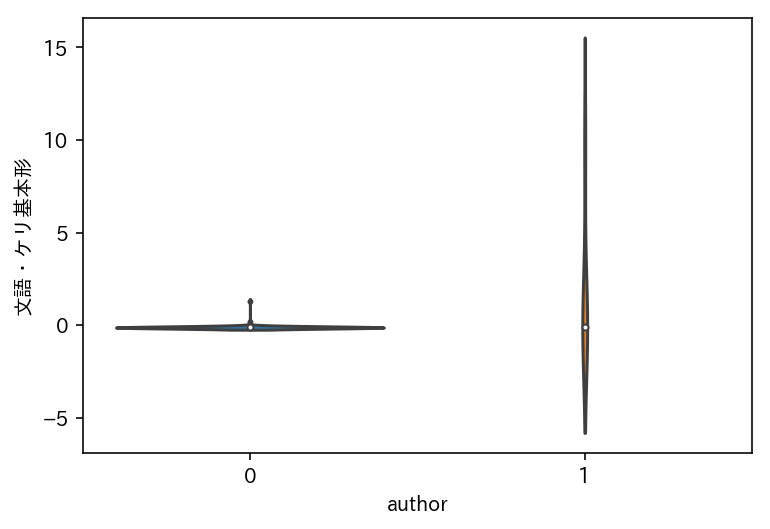

-1.6394933870189274
0.1611313737126311 4.0601831920499665


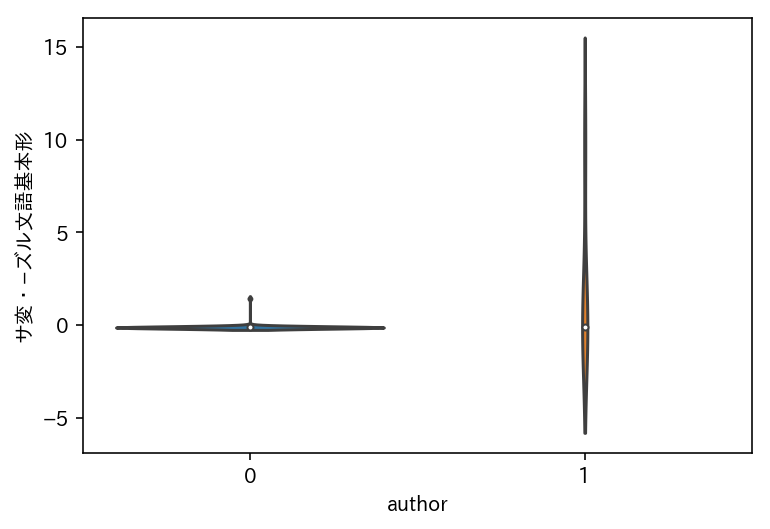

-1.6156453217538544
0.19587707209872113 4.042515176224923


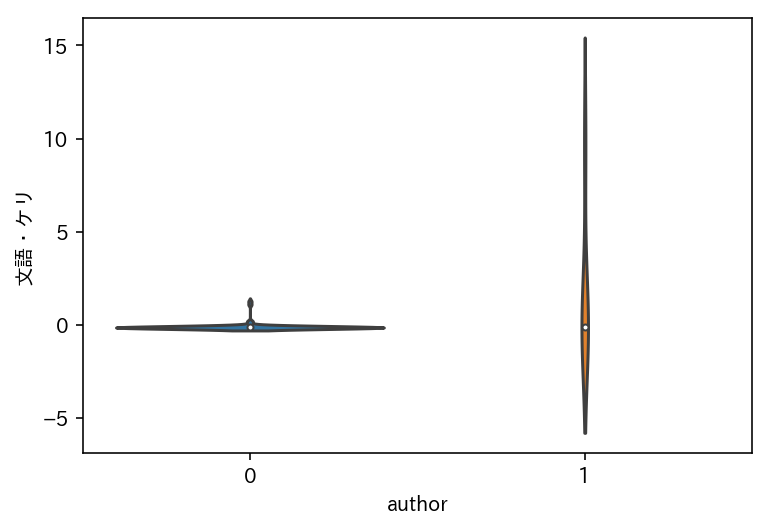

-1.542395275154348
0.8722195903124963 1.7793932989200791


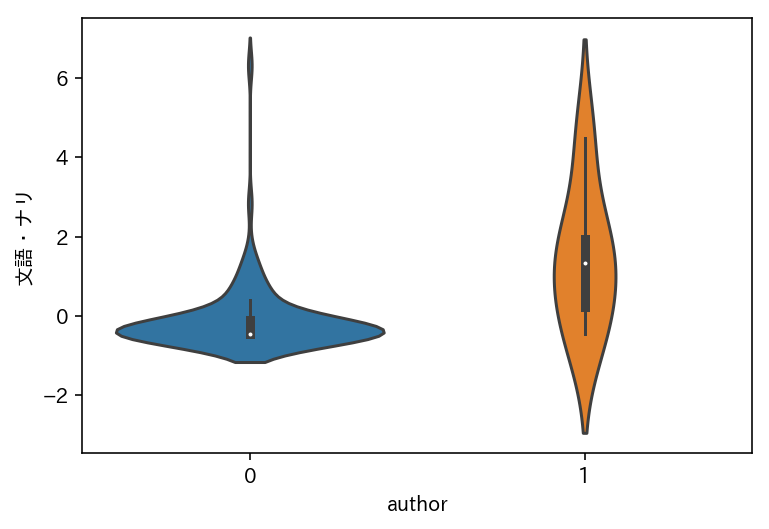

-1.450589933978866
0.4224152840075884 3.7825341919358326


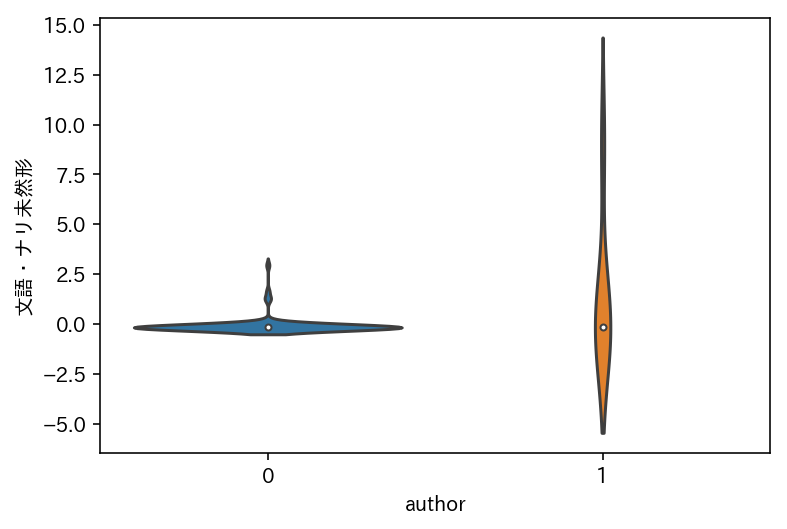

-1.384843129516496
0.4988069932166317 3.634404459731738


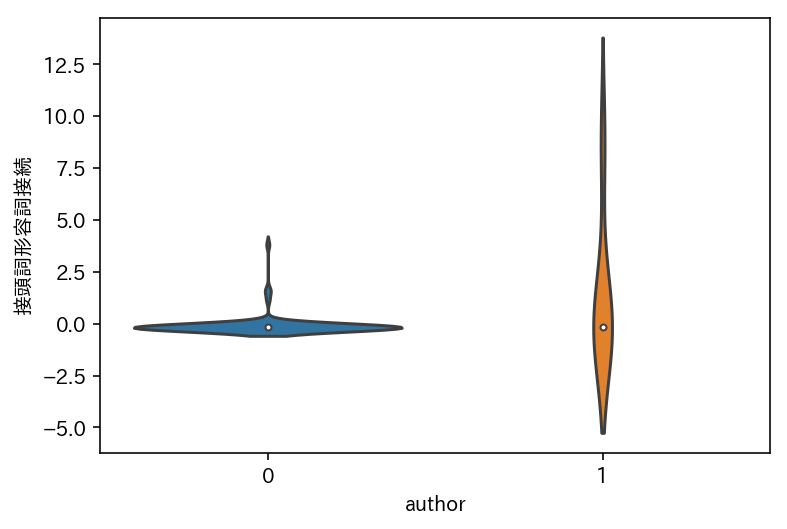

-1.384843129516496
0.4988069932166317 3.634404459731738


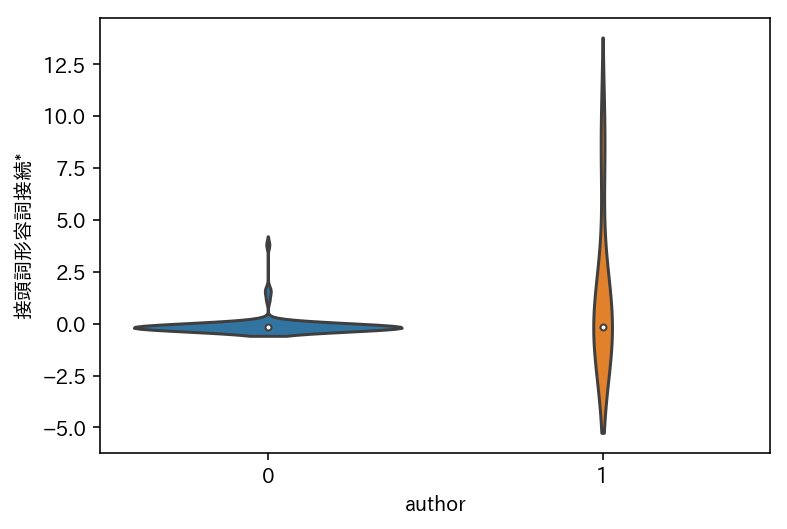

-1.336045330511637
0.46416126886668835 3.7388783036357816


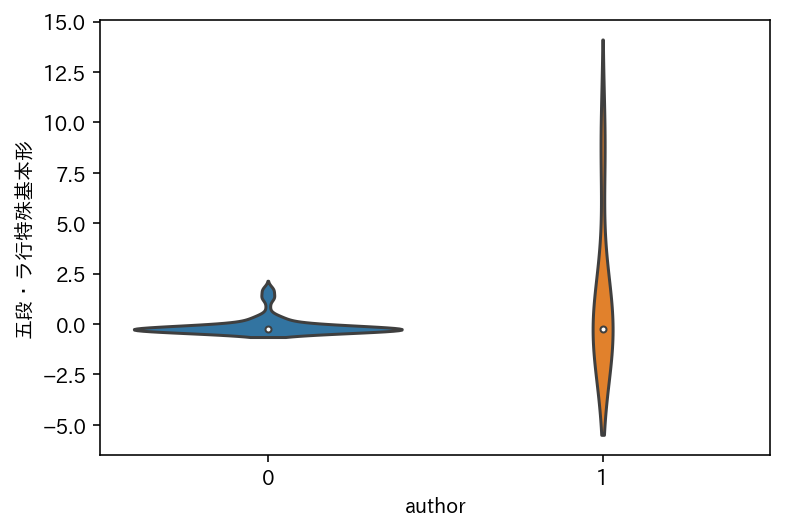

-1.3131628128319222
0.8905911566120238 1.8172072398242576


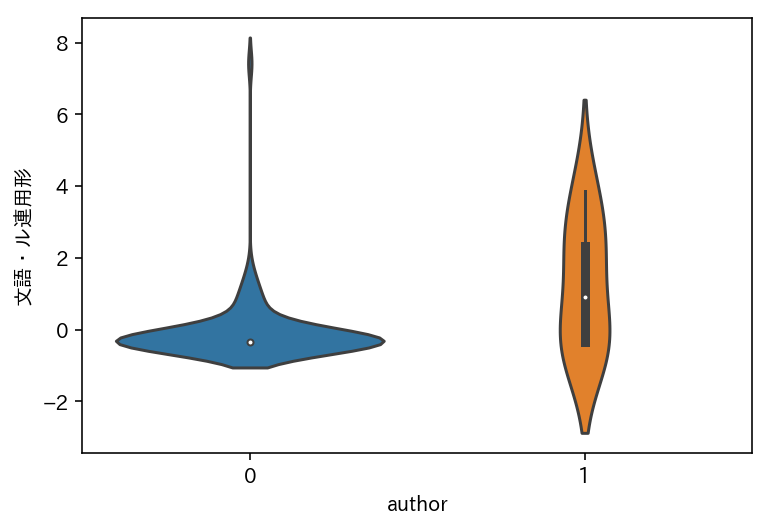

-1.2211833358673936
0.6299419214426538 3.307090468649944


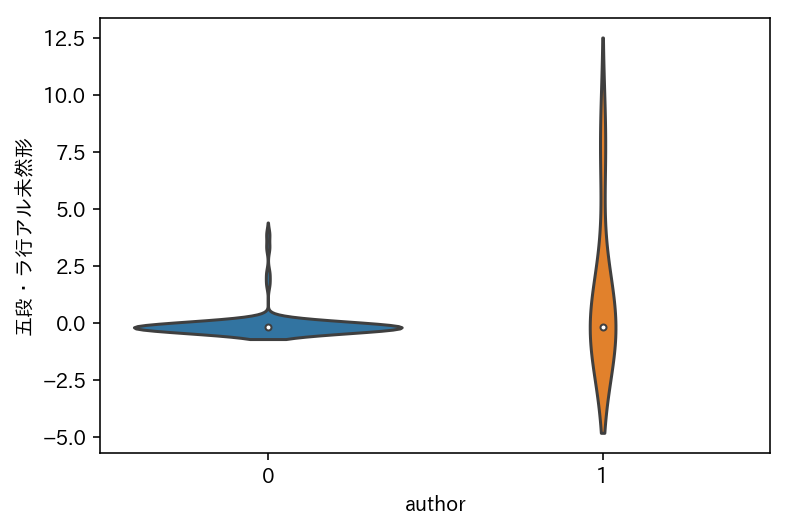

-1.1973306233021113
0.6435216513538405 3.26806737167298


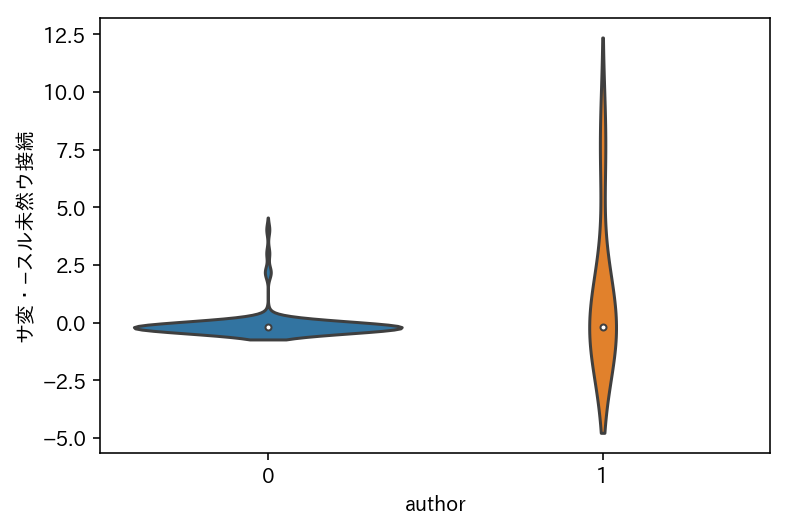

-1.1954083553649797
0.8034538924637428 2.5260793717625365


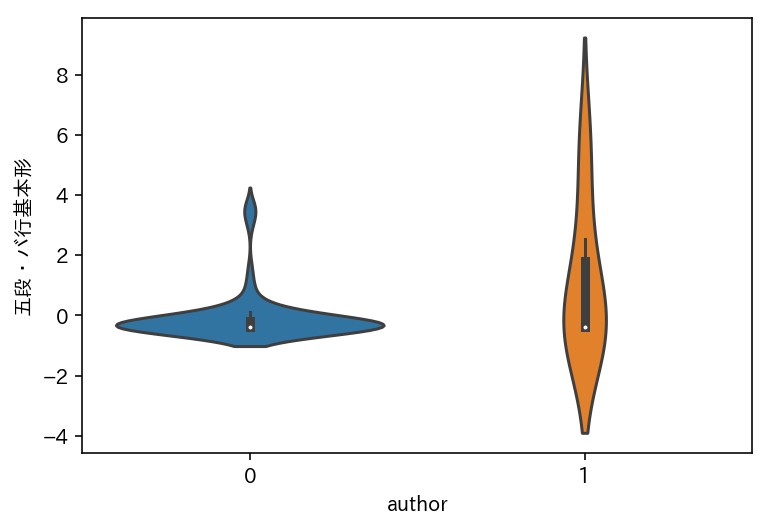

1.1452082430596646
0.9941925818116355 0.3688285310372584


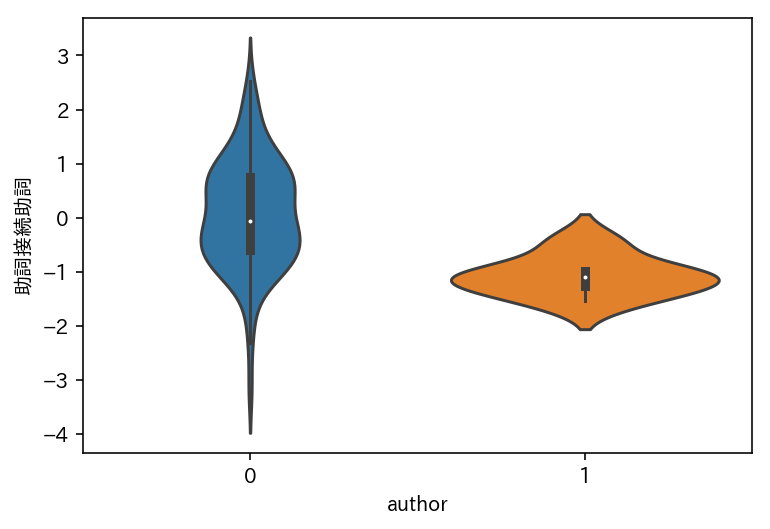

1.1452082430596646
0.9941925818116355 0.3688285310372584


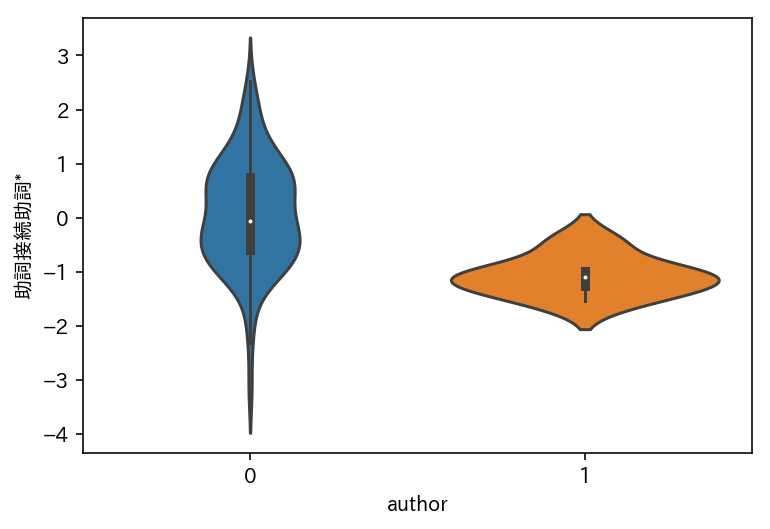

-1.1412438142748142
0.8830292102283309 2.0069069888337383


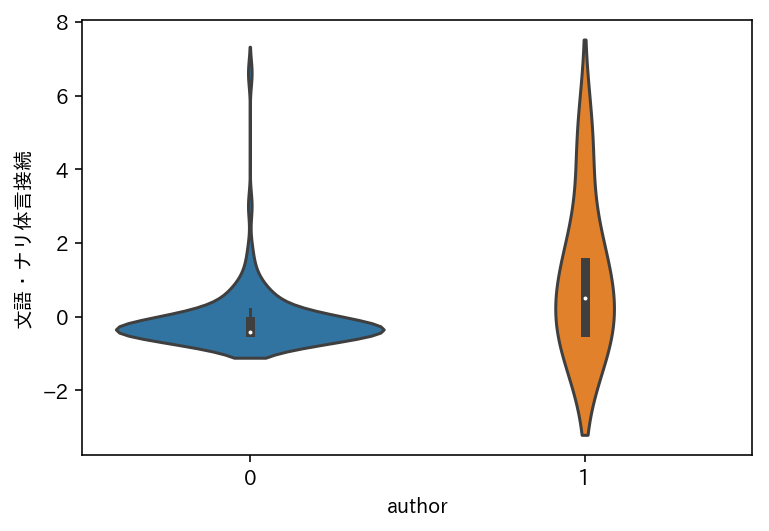

1.0561217711377566
0.9898940354663741 0.7182469829405064


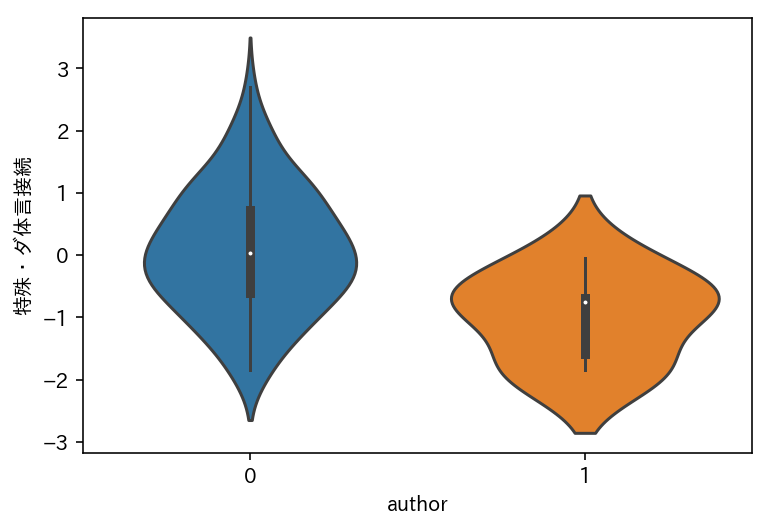

-1.0541520361420225
0.6736608647024345 3.2102168996799247


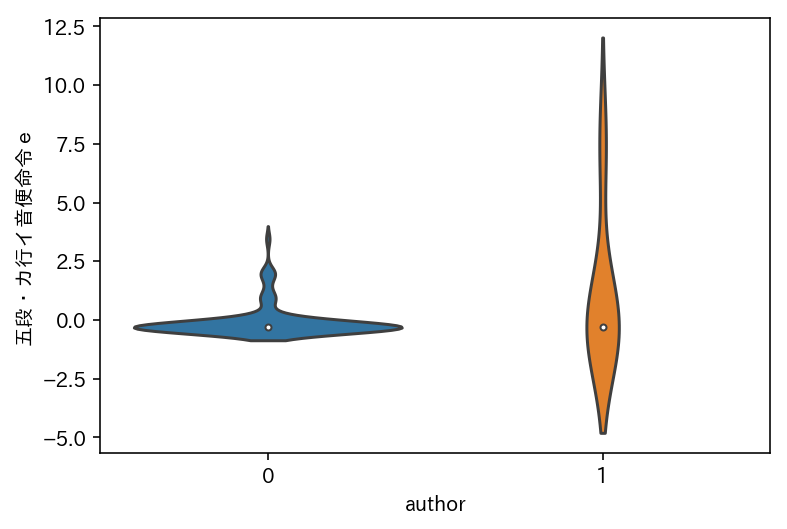

-1.0499391540443068
0.9309252218553252 1.6239948368627664


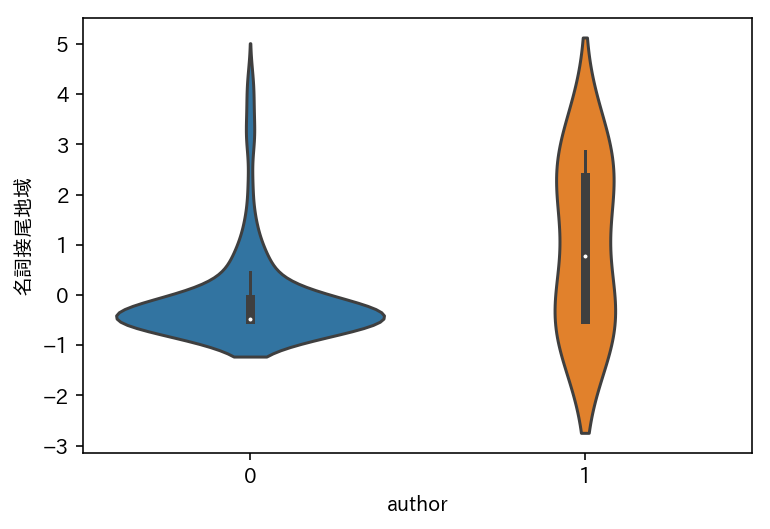

-1.0440044878584096
0.9615845417697001 1.2538531675741227


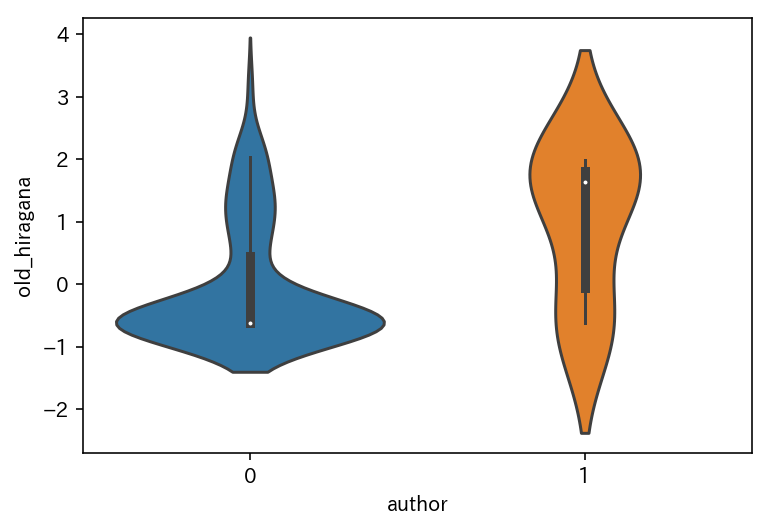

-1.0338996239602636
0.95126868464666 1.4010213827710885


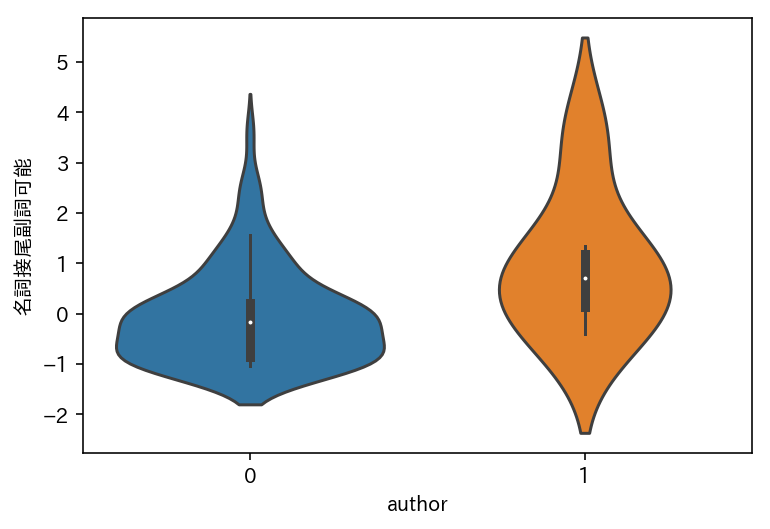

-1.0134955972212354
0.9074270637368536 1.8776752634838698


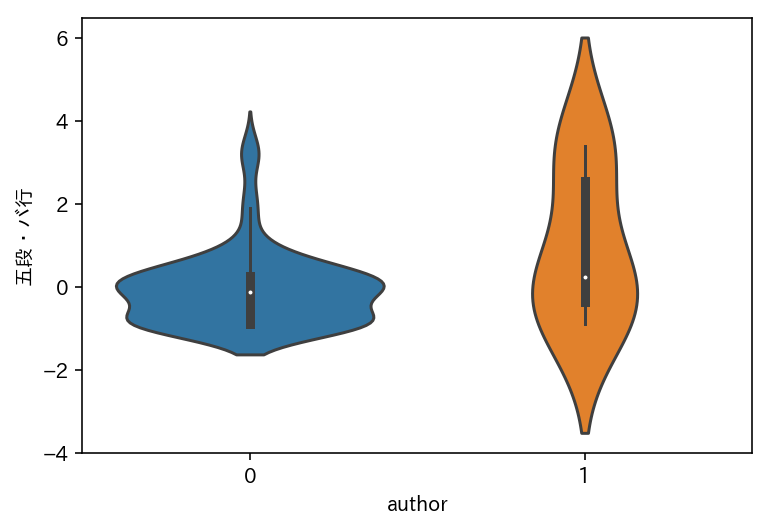

-1.0113240055067392
0.8892972005541455 2.033840577245229


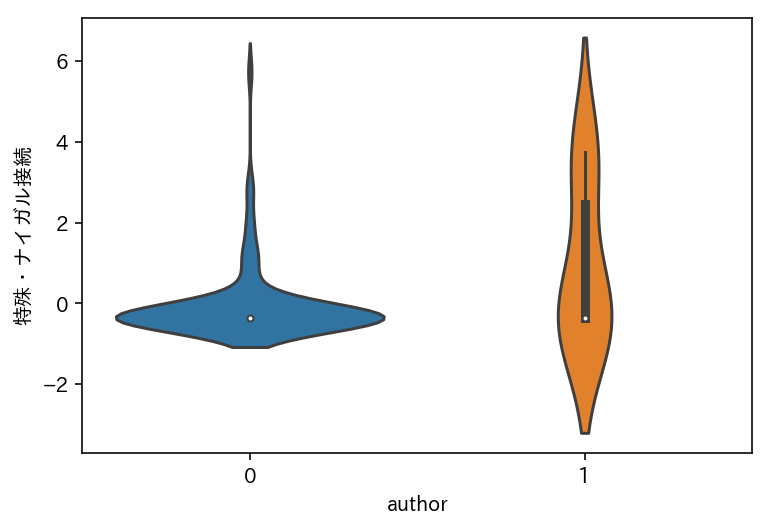

In [106]:
for col in diff.index:
    if abs(diff[col])>1.:
        print(pd.Series(tmp[tmp["author"]==0].mean()-tmp[tmp["author"]==1].mean(), name="val").sort_values(ascending=False)[col])
        print(pd.Series(tmp[tmp["author"]==0].std(), name="val").sort_values(ascending=False)[col],
              pd.Series(tmp[tmp["author"]==1].std(), name="val").sort_values(ascending=False)[col])
        sns.violinplot(y=col, x="author", data=tmp)
        plt.title = col
        plt.show()

In [86]:
tmp[tmp["author"]==0].describe()

,author,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,...,下二・ガ行体言接続,特殊・タイ文語基本形,五段・ワ行ウ音便未然形,五段・ワ行ウ音便基本形,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
count,94.0,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.0,0.020145,-0.029453,0.050134,-0.002641,-0.034740,-0.002438,0.015655,-0.062640,0.001580,...,0.006415,0.006415,0.006415,0.006415,0.017248,0.005862,-0.043294,0.022700,-0.001758,-0.002116
std,0.0,1.033592,1.021082,1.012163,0.994652,0.971515,1.028191,1.034626,0.961585,1.035340,...,1.036617,1.036617,1.036617,1.036617,1.031042,0.994045,0.993793,1.027946,1.019201,1.024989
min,0.0,-0.398695,-3.462989,-3.311487,-0.936176,-0.556696,-0.216774,-0.394963,-0.627461,-0.499640,...,-0.100504,-0.100504,-0.100504,-0.100504,-3.317909,-2.906358,-4.241696,-4.383303,-2.518368,-1.286162
25%,0.0,-0.343566,-0.381170,-0.454279,-0.687229,-0.556696,-0.216774,-0.379310,-0.627461,-0.483580,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.606267,-0.515006,-0.495422,-0.483681,-0.588789,-0.682872
50%,0.0,-0.243516,0.087756,0.158294,-0.349731,-0.556696,-0.216774,-0.352415,-0.627461,-0.450764,...,-0.100504,-0.100504,-0.100504,-0.100504,0.062356,0.006870,0.056759,-0.081341,-0.080696,-0.264650
75%,0.0,0.017901,0.572942,0.745306,0.280361,-0.023464,-0.177054,-0.216992,0.448744,0.013247,...,-0.100504,-0.100504,-0.100504,-0.100504,0.576570,0.417031,0.491302,0.643051,0.361703,0.360680
max,0.0,7.269735,2.400598,2.879913,3.585162,4.368388,9.456151,3.502257,3.172471,3.723206,...,9.949874,9.949874,9.949874,9.949874,2.869866,3.434374,2.553843,2.989460,3.277104,4.220042


In [87]:
tmp[tmp["author"]==1].describe()

,author,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,...,下二・ガ行体言接続,特殊・タイ文語基本形,五段・ワ行ウ音便未然形,五段・ワ行ウ音便基本形,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
count,6.0,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000e+00,6.000000e+00,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,1.0,-0.315600,0.461425,-0.785425,0.041375,0.544268,0.038190,-0.245267,0.981364,-0.024752,...,-0.100504,-1.005038e-01,-1.005038e-01,-0.100504,-0.270219,-0.091837,0.678267,-0.355633,0.027548,0.033148
std,0.0,0.047386,0.579375,0.396547,1.263413,1.437491,0.578504,0.113265,1.253853,0.247676,...,0.000000,1.520235e-17,1.520235e-17,0.000000,0.366189,1.268891,1.021228,0.429441,0.823339,0.676303
min,1.0,-0.369258,-0.256109,-1.331411,-0.936176,-0.556696,-0.216774,-0.394963,-0.627461,-0.390330,...,-0.100504,-1.005038e-01,-1.005038e-01,-0.100504,-0.819028,-2.125746,-0.522161,-0.850087,-0.973248,-0.688784
25%,1.0,-0.339983,-0.010753,-1.015255,-0.758133,-0.479339,-0.216774,-0.325876,-0.061945,-0.184520,...,-0.100504,-1.005038e-01,-1.005038e-01,-0.100504,-0.457507,-0.699799,-0.037535,-0.710529,-0.576066,-0.440468
50%,1.0,-0.325547,0.535315,-0.816019,-0.684749,-0.153696,-0.216774,-0.244606,1.636650,0.033601,...,-0.100504,-1.005038e-01,-1.005038e-01,-0.100504,-0.269247,0.184054,0.529554,-0.372740,0.040985,-0.174749
75%,1.0,-0.303601,0.868847,-0.514183,1.036402,1.389162,-0.144330,-0.152026,1.817060,0.131871,...,-0.100504,-1.005038e-01,-1.005038e-01,-0.100504,0.008892,0.698532,1.409345,0.000396,0.571185,0.585960
max,1.0,-0.232170,1.166783,-0.253865,1.726397,2.814132,1.216420,-0.113293,1.993294,0.267216,...,-0.100504,-1.005038e-01,-1.005038e-01,-0.100504,0.154864,1.331008,2.056612,0.160122,1.090395,0.926682


In [107]:
tmp = pd.concat([
    train["author"][:num_sample],
    hyoki_df,
    word_df,
    adjective0_df,
#     adjective1_df,
#     adjective2_df,
    adjective01_df,
    adjective012_df,
    katsuyo0_df,
#     katsuyo1_df,
    katsuyo01_df,
    negaposi_df],
    axis=1)
tmp

,author,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,...,下二・ガ行体言接続,特殊・タイ文語基本形,五段・ワ行ウ音便未然形,五段・ワ行ウ音便基本形,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
0,0,651.0,0.298003,0.594470,0.036866,0.000000,0.000000,0.001536,0.000000,0.001536,...,0.002336,0.000000,0.000000,0.0,-0.008959,-0.026133,0.001534,0.033558,-0.149220,0.025111
1,0,1363.0,0.319883,0.562729,0.026412,0.000000,0.000000,0.000000,0.005136,0.005136,...,0.000000,0.000000,0.000000,0.0,-0.001320,-0.051084,0.027209,0.025195,-0.133101,0.036453
2,0,482.0,0.338174,0.556017,0.051867,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,-0.006494,0.000760,-0.021711,0.027444,-0.190386,0.020553
3,1,4301.0,0.332946,0.526157,0.004185,0.004185,0.000465,0.000698,0.007673,0.008370,...,0.000000,0.000000,0.000000,0.0,-0.005741,0.004553,0.010287,-0.009100,-0.174365,0.008987
4,0,4273.0,0.334659,0.578750,0.001170,0.000000,0.000468,0.000468,0.000000,0.000468,...,0.000000,0.000000,0.000000,0.0,-0.024023,0.023435,-0.005564,0.006152,-0.176879,0.019959
5,0,16845.0,0.287029,0.557673,0.022737,0.000594,0.001306,0.000712,0.000000,0.000712,...,0.000000,0.000000,0.000000,0.0,0.002984,0.001738,-0.004676,-0.000046,-0.155715,0.003356
6,0,2722.0,0.273328,0.666789,0.008817,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,-0.012257,-0.003049,0.013151,0.002154,-0.144991,0.010601
7,1,2319.0,0.270806,0.567055,0.068564,0.000000,0.006900,0.003450,0.007331,0.010781,...,0.000000,0.000000,0.000000,0.0,-0.006974,-0.017298,0.041292,-0.017020,-0.110433,0.027944
8,0,11568.0,0.295816,0.552472,0.016425,0.001037,0.000000,0.049101,0.002334,0.051435,...,0.000000,0.000000,0.000000,0.0,0.007921,-0.009098,0.009120,-0.007944,-0.130927,0.009862
9,0,9791.0,0.279542,0.582065,0.071903,0.000000,0.000409,0.000204,0.000000,0.000204,...,0.000000,0.000000,0.000000,0.0,-0.019600,0.001547,0.000193,0.017860,-0.135904,0.015336


In [108]:
tmp.iloc[:, 1:] = tmp.iloc[:, 1:].apply(zscore, axis=0)

In [109]:
diff = pd.Series(tmp[tmp["author"]==0].mean()-tmp[tmp["author"]==1].mean(), name="val").map(abs).sort_values(ascending=False)

In [110]:
sum(pd.Series(tmp[tmp["author"]==0].mean()-tmp[tmp["author"]==1].mean(), name="val").map(abs) > 1)

902

In [117]:
diff[:60]

軽蔑             2.612395
対岸             2.378657
じらい            2.307424
爾来             2.306815
褒める            2.304689
懸ける            2.302548
おの             2.292963
初              2.274716
薔薇             2.270175
頂戴             2.266876
心もち            2.259673
寧              2.230724
もむ             2.225071
むし             2.214184
五段・ラ行体言接続特殊    2.204405
大正             2.199132
等              2.191291
札              2.179708
無用             2.172131
勿論             2.162605
程なく            2.119194
残す             2.099541
到底             2.081677
かす             2.079819
槍              2.074592
すく             2.051429
感謝             2.046049
壺              2.038056
あぶる            2.022300
位              2.022135
後              2.005920
牛馬             1.993980
感ずる            1.990397
唯              1.976347
剥げる            1.960893
幾つ             1.928608
始              1.882531
立ち去る           1.872445
ろう             1.872084
ふる             1.832243
一団             1.830079
はり             1

In [119]:
from sklearn.manifold import TSNE

In [121]:
tmp.drop(["author"], axis=1)

,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,lowercase,...,下二・ガ行体言接続,特殊・タイ文語基本形,五段・ワ行ウ音便未然形,五段・ワ行ウ音便基本形,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
0,-0.379555,0.119096,0.190777,0.432014,-0.556696,-0.216774,-0.277997,-0.627461,-0.390372,-0.443037,...,9.949874,-0.100504,-0.100504,-0.100504,-0.423561,-1.468881,0.057771,1.638279,-0.161612,0.570195
1,-0.350805,0.420946,-0.324019,0.044042,-0.556696,-0.216774,-0.394963,1.126759,-0.134317,-1.146996,...,-0.100504,-0.100504,-0.100504,-0.100504,0.029559,-2.810949,1.348595,1.226858,0.358692,1.455822
2,-0.386379,0.673297,-0.432890,0.988729,-0.556696,-0.216774,-0.394963,-0.627461,-0.499640,0.944726,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.277350,-0.022319,-1.110872,1.337507,-1.490395,0.214306
3,-0.232170,0.601166,-0.917181,-0.780859,2.814132,-0.120181,-0.341851,1.993294,0.095758,-1.146996,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.232678,0.181698,0.497834,-0.460392,-0.973248,-0.688784
4,-0.233300,0.624807,-0.064178,-0.892750,-0.556696,-0.119548,-0.359323,-0.627461,-0.466345,1.212494,...,-0.100504,-0.100504,-0.100504,-0.100504,-1.317196,1.197288,-0.299090,0.289973,-1.054401,0.167917
5,0.274351,-0.032305,-0.406027,-0.092367,-0.078548,0.054518,-0.340719,-0.627461,-0.448966,0.980477,...,-0.100504,-0.100504,-0.100504,-0.100504,0.284940,0.030235,-0.254473,-0.014947,-0.371257,-1.128468
6,-0.295929,-0.221315,1.363704,-0.608957,-0.556696,-0.216774,-0.394963,-0.627461,-0.499640,0.671298,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.619212,-0.227207,0.641834,0.093274,-0.025105,-0.562811
7,-0.312202,-0.256109,-0.253865,1.608384,-0.556696,1.216420,-0.132281,1.876514,0.267216,-1.146996,...,-0.100504,-0.100504,-0.100504,-0.100504,-0.305817,-0.993631,2.056612,-0.850087,1.090395,0.791394
8,0.061268,0.088924,-0.490374,-0.326623,0.278824,-0.216774,3.343827,0.169776,3.159111,-1.146996,...,-0.100504,-0.100504,-0.100504,-0.100504,0.577803,-0.552572,0.439166,-0.403537,0.428860,-0.620463
9,-0.010486,-0.135587,-0.010415,1.732292,-0.556696,-0.131911,-0.379409,-0.627461,-0.485109,0.640992,...,-0.100504,-0.100504,-0.100504,-0.100504,-1.054805,0.019980,-0.009665,0.865978,0.268219,-0.193080


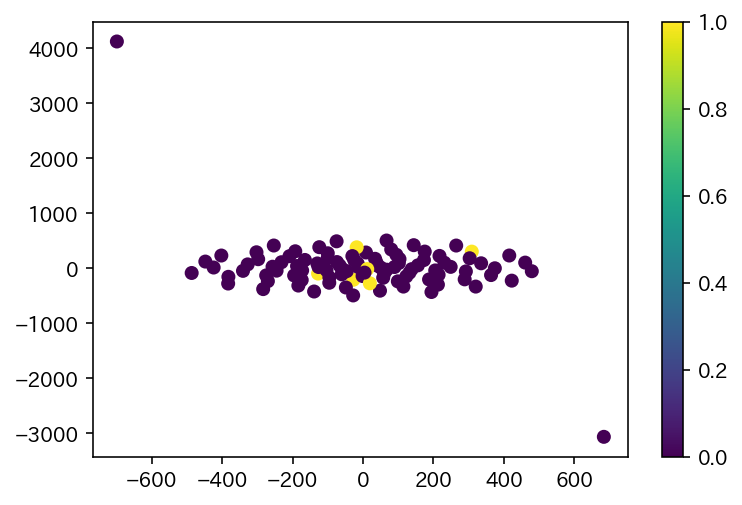

In [126]:
tmp_reduced = TSNE(n_components=2, random_state=0).fit_transform(tmp.drop(["author"], axis=1))

plt.scatter(tmp_reduced[:, 0], tmp_reduced[:, 1], c=tmp["author"])
plt.colorbar()

import sys
sys.path.append('./')
from vectorizer import Vectorizer, SCDV, SWEM
from utility import FeatureComposition
from extractor import Extractor

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_subtitles_raw)
tfidf_matrix = tokenizer.texts_to_matrix(X_subtitles_raw, "tfidf")

from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier().fit(tfidf_matrix, labels)
feature_importances = ridge.coef_[:, 1:]

for i in np.argsort(-np.abs(feature_importances[1]))[:100]:
    print(tokenizer.index_word[i+1])

feature_importances[:, tokenizer.word_index['shadowverse']]

from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

visions_average = Pipeline([
                    ("swem", SWEM(pooling="average")),
                    ("decomp", PCA(210)),
                    ("classifier", lgb.LGBMClassifier(random_state=0, n_estimators=100))
    ])

X_train, X_test, y_train, y_test = train_test_split(X_visions_web, labels, test_size=70, random_state=0)
visions_average.fit(X_train, y_train).score(X_test, y_test)